In [248]:
import requests
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import plotly.offline as py


from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA

In [249]:
confirmed= pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths= pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoverd=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [250]:
confirmed.head()
deaths.head()
recoverd.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  6/3/20  6/4/20  6/5/20  6/6/20  6/7/20  \
0        0        0        0  ...    1522    1585    1762    1830    1875   
1        0        0        0  ...     898     898     910     925     938   
2        0        0        0  ...    6218    6297    6453    6631    6717   
3        0        0        0  ...     735     738     741     741     744   
4        0        0        0  ...      18      18      21      24      24   

   6/8/20  6/9/20  6/10/20  6/11/20  6/12/20  
0    2171    2651     3013     3326     3928  
1     945     960      980     1001     1034  
2    6799    6951     7074     7255     7322  
3     751     757      759      780      781  
4      38      38       40       41       42  

[5 rows x 147 columns]

We have data regarding number of confirmed cases, deaths and recovered cases from Jan 22 till May31 

In [251]:
confirmed.shape
deaths.shape
recoverd.shape

(253, 147)

Unpivoting the data using dates as variables and then merging confirmed, deaths and recovered tables 
Number of countries in recoverd table are less than those in confirmed and deaths table. Assuming that the missing countries have zero recovery cases and hence replacing null values with"0". 

In [252]:
confirmed_df = confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=confirmed.columns[4:], var_name='Date', value_name='Confirmed')

deaths_df = deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=confirmed.columns[4:], var_name='Date', value_name='Deaths')
recovered_df =recoverd.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=confirmed.columns[4:], var_name='Date', value_name='Recovered')

In [409]:
recovered_df.head()

Province/State Country/Region      Lat     Long     Date  Recovered
0            NaN    Afghanistan  33.0000  65.0000  1/22/20          0
1            NaN        Albania  41.1533  20.1683  1/22/20          0
2            NaN        Algeria  28.0339   1.6596  1/22/20          0
3            NaN        Andorra  42.5063   1.5218  1/22/20          0
4            NaN         Angola -11.2027  17.8739  1/22/20          0

In [430]:
World_Data = pd.merge (confirmed_df,deaths_df,how='left', on= ['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'] )
World_Data = pd.merge (World_Data,recovered_df,how='left', on= ['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'] )

In [431]:
print(World_Data.shape)
World_Data.head()

(38038, 8)


Province/State Country/Region      Lat     Long     Date  Confirmed  Deaths  \
0            NaN    Afghanistan  33.0000  65.0000  1/22/20          0       0   
1            NaN        Albania  41.1533  20.1683  1/22/20          0       0   
2            NaN        Algeria  28.0339   1.6596  1/22/20          0       0   
3            NaN        Andorra  42.5063   1.5218  1/22/20          0       0   
4            NaN         Angola -11.2027  17.8739  1/22/20          0       0   

   Recovered  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [432]:
World_Data.isna().sum()

Province/State    26455
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered          2574
dtype: int64

In [433]:
World_Data[World_Data['Recovered'].isna()]['Country/Region'].value_counts()

Canada            2002
Timor-Leste        143
United Kingdom     143
Mozambique         143
Syria              143
Name: Country/Region, dtype: int64

High number of missing values for Canada's recovery data are observed. 

In [434]:
Null_df = World_Data[World_Data['Recovered'].isna()].groupby(['Date','Country/Region'])

In [435]:
World_Data=World_Data.fillna(0)

#World_Data=World_Data.drop(columns=['Province/State'])
World_Data.rename(columns={'Country/Region':'Country'},inplace=True)

In [436]:
World_Data.isna().sum()

Province/State    0
Country           0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
dtype: int64

In [437]:
print(World_Data.shape)
World_Data.head()


(38038, 8)


Province/State      Country      Lat     Long     Date  Confirmed  Deaths  \
0              0  Afghanistan  33.0000  65.0000  1/22/20          0       0   
1              0      Albania  41.1533  20.1683  1/22/20          0       0   
2              0      Algeria  28.0339   1.6596  1/22/20          0       0   
3              0      Andorra  42.5063   1.5218  1/22/20          0       0   
4              0       Angola -11.2027  17.8739  1/22/20          0       0   

   Recovered  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [438]:
World_Data['Recovered'] = World_Data['Recovered'].astype('int')
World_Data['Deaths'] = World_Data['Deaths'].astype('int')

In [439]:
World_Data.head()

Province/State      Country      Lat     Long     Date  Confirmed  Deaths  \
0              0  Afghanistan  33.0000  65.0000  1/22/20          0       0   
1              0      Albania  41.1533  20.1683  1/22/20          0       0   
2              0      Algeria  28.0339   1.6596  1/22/20          0       0   
3              0      Andorra  42.5063   1.5218  1/22/20          0       0   
4              0       Angola -11.2027  17.8739  1/22/20          0       0   

   Recovered  
0          0  
1          0  
2          0  
3          0  
4          0

In [440]:
World_Data[World_Data['Country']=='India'].tail()

Province/State Country   Lat  Long     Date  Confirmed  Deaths  \
36839              0   India  21.0  78.0   6/8/20     265928    7473   
37105              0   India  21.0  78.0   6/9/20     276146    7750   
37371              0   India  21.0  78.0  6/10/20     286605    8498   
37637              0   India  21.0  78.0  6/11/20     297535    8498   
37903              0   India  21.0  78.0  6/12/20     297535    8498   

       Recovered  
36839     129095  
37105     134670  
37371     135206  
37637     147195  
37903     147195

In [441]:
World_Data.to_csv('Covid_World_Data.csv',index= False)

In [442]:
World_Data['Date']=pd.to_datetime(World_Data['Date'])
World_Data.head()

Province/State      Country      Lat     Long       Date  Confirmed  Deaths  \
0              0  Afghanistan  33.0000  65.0000 2020-01-22          0       0   
1              0      Albania  41.1533  20.1683 2020-01-22          0       0   
2              0      Algeria  28.0339   1.6596 2020-01-22          0       0   
3              0      Andorra  42.5063   1.5218 2020-01-22          0       0   
4              0       Angola -11.2027  17.8739 2020-01-22          0       0   

   Recovered  
0          0  
1          0  
2          0  
3          0  
4          0

In [443]:
World_Data.loc[World_Data['Country']=='Congo (Brazzaville)','Country']='DR Congo'

World_Data.loc[World_Data['Country']=='Congo (Kinshasa)','Country']='DR Congo'
World_Data.loc[World_Data['Country']=='Taiwan*','Country']='Taiwan'

Multiple entries for countries are merged to get cumulative data 


In [444]:
#!pip install folium
#!pip install plotly_express
#import folium
#import plotly as px
#Getting Recent information 
#df_w= World_Data[World_Data['Date']==max(World_Data['Date'])]
#gmap = folium.Map(zoom_start=1.5)
#for i in range(0, len(df_w)):
    #folium.Circle(
        #location=[df_w.iloc[i]['Lat'], df_w.iloc[i]['Long']],
        #color='black', fill='red',
        #tooltip =   '<li><bold>Country : '+str(df_w.iloc[i]['Country'])+'<li><bold>Province : '+str(df_w.iloc[i]['Province/State'])+'<li><bold>Confirmed : '+str(df_w.iloc[i]['Confirmed'])+
         #           '<li><bold>Deaths : '+str(df_w.iloc[i]['Deaths']),
        #radius=int(df_w.iloc[i]['Confirmed'])**0.5).add_to(gmap)

#gmap









In [445]:
World_Data['Active']= World_Data['Confirmed']-World_Data['Deaths']-World_Data['Recovered']
World_Data = World_Data.groupby(['Date', 'Country'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
World_Data.head()

Date      Country  Confirmed  Deaths  Recovered  Active
0 2020-01-22  Afghanistan          0       0          0       0
1 2020-01-22      Albania          0       0          0       0
2 2020-01-22      Algeria          0       0          0       0
3 2020-01-22      Andorra          0       0          0       0
4 2020-01-22       Angola          0       0          0       0

In [473]:
k=0
for i in df['Country']:
    temp=df[df['Country']==i].reset_index()
    temp['Conf']=temp['Confirmed'].shift(1)
    print(i)
    for j in temp['Date']:
        if temp[temp['Date']==j]['Confirmed'] < temp[temp['Date']==j]['Conf']:
            k=k+1
    print(k)

Afghanistan


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [474]:
print(max(World_Data['Date']))
World=World_Data.copy()
World['Date']=World['Date']+datetime.timedelta(days=1)

#World.tail()
#World[World['Country']=='China']
World.rename(columns={'Confirmed':'Confirmed_n','Active':'Active_n','Recovered':'Recovered_n','Deaths':'Deaths_n'},inplace=True)
World['Confirmed_n']=World['Confirmed_n'].astype(int)
World['Active_n']=World['Active_n'].astype(int)
World['Deaths_n']=World['Deaths_n'].astype(int)
World['Recovered_n']=World['Recovered_n'].astype(int)

World=World.join(World_Data.set_index(['Date','Country'])[['Confirmed','Active','Deaths','Recovered']],on=['Date','Country'])
#World=World.dropna(subset=['Confirmed','Active','Deaths','Recovered'])
World.drop(World.loc[World['Date']==max(World['Date'])].index,inplace=True)
World['Recovered']=World['Recovered'].astype(int)
World['Confirmed']=World['Confirmed'].astype(int)
World['Active']=World['Active'].astype(int)
World['Deaths']=World['Deaths'].astype(int)
World[(World['Country']=='China')&(World['Date']>'2020-06-01')]




2020-06-12 00:00:00


Date Country  Confirmed_n  Deaths_n  Recovered_n  Active_n  \
24533 2020-06-02   China        84154      4638        79398       118   
24720 2020-06-03   China        84161      4638        79400       123   
24907 2020-06-04   China        84160      4638        79404       118   
25094 2020-06-05   China        84171      4638        79415       118   
25281 2020-06-06   China        84177      4638        79420       119   
25468 2020-06-07   China        84186      4638        79424       124   
25655 2020-06-08   China        84191      4638        79434       119   
25842 2020-06-09   China        84195      4638        79444       113   
26029 2020-06-10   China        84198      4638        79451       109   
26216 2020-06-11   China        84209      4638        79456       115   
26403 2020-06-12   China        84216      4638        79464       114   

       Confirmed  Active  Deaths  Recovered  
24533      84161     123    4638      79400  
24720      84160     118    4638      79404  
24907      84171     118    4638      79415  
25094      84177     119    4638      79420  
25281      84186     124    4638      79424  
25468      84191     119    4638      79434  
25655      84195     113    4638      79444  
25842      84198     109    4638      79451  
26029      84209     115    4638      79456  
26216      84216     114    4638      79464  
26403      84228     118    4638      79472

#Eliminate mistakes like reduced confirmed cases or deaths or recoveries with time. If confirmed cases on previous day are more than today, then set today's data equal to yesterday's

In [ ]:
k=0
for i in World['Country']:
    for j in World['Date']:
        mask = World[(World['Country']==i)&(World['Date']==j)]['Confirmed'] < World[(World['Country']==i)&(World['Date']==j)]['Confirmed_n']
        World.loc[(World['Country']==i)&(World['Date']==j),'Confirmed'][mask]= World[(World['Country']==i)&(World['Date']==j)]['Confirmed_n']


In [ ]:

for i in World['Country']:
    for j in World['Date']:
        mask = World[(World['Country']==i)&(World['Date']==j)]['Recovered'] < World[(World['Country']==i)&(World['Date']==j)]['Recovered_n']
        World.loc[(World['Country']==i)&(World['Date']==j),'Recovered'][mask]= World[(World['Country']==i)&(World['Date']==j)]['Recovered_n']


In [ ]:

for i in World['Country']:
    for j in World['Date']:
        mask = World[(World['Country']==i)&(World['Date']==j)]['Deaths'] < World[(World['Country']==i)&(World['Date']==j)]['Deaths_n']
        World.loc[(World['Country']==i)&(World['Date']==j),'Deaths'][mask]= World[(World['Country']==i)&(World['Date']==j)]['Deaths_n']


In [475]:
World['Confirmed_n']=World['Confirmed'].astype(int)-World['Confirmed_n'].astype(int)
World['Active_n']=World['Active'].astype(int)-World['Active_n'].astype(int)
World['Deaths_n']=World['Deaths'].astype(int)-World['Deaths_n'].astype(int)
World['Recovered_n']=World['Recovered'].astype(int)-World['Recovered_n'].astype(int)

World.head()


Date      Country  Confirmed_n  Deaths_n  Recovered_n  Active_n  \
0 2020-01-23  Afghanistan            0         0            0         0   
1 2020-01-23      Albania            0         0            0         0   
2 2020-01-23      Algeria            0         0            0         0   
3 2020-01-23      Andorra            0         0            0         0   
4 2020-01-23       Angola            0         0            0         0   

   Confirmed  Active  Deaths  Recovered  
0          0       0       0          0  
1          0       0       0          0  
2          0       0       0          0  
3          0       0       0          0  
4          0       0       0          0

In [476]:
World_Data= World_Data.join(World.set_index(['Date','Country'])[['Confirmed_n','Active_n','Deaths_n','Recovered_n']],on=['Date','Country'],how='left')
World_Data['Confirmed_n']=World_Data['Confirmed_n'].fillna(World_Data['Confirmed'])
World_Data['Active_n']=World_Data['Active_n'].fillna(World_Data['Active'])
World_Data['Recovered_n']=World_Data['Recovered_n'].fillna(World_Data['Recovered'])
World_Data['Deaths_n']=World_Data['Deaths_n'].fillna(World_Data['Deaths'])
#World_Data[World_Data['Date']=='2020-01-22'].head()

World_Data.head()
print(str(World_Data[World_Data['Confirmed_n']<0]['Date'].count())+' Confirmed new cases are negative')
print(str(World_Data[World_Data['Deaths_n']<0]['Date'].count())+' Confirmed new cases are negative')
print(str(World_Data[World_Data['Recovered_n']<0]['Date'].count())+' Confirmed new cases are negative')

30 Confirmed new cases are negative
23 Confirmed new cases are negative
55 Confirmed new cases are negative


In [483]:
World_Data.loc[World_Data['Confirmed_n']<0,'Confirmed_n']=0
World_Data.loc[World_Data['Recovered_n']<0,'Recovered_n']=0
World_Data.loc[World_Data['Deaths_n']<0,'Deaths_n']=0
print(str(World_Data[World_Data['Confirmed_n']<0]['Date'].count())+' Confirmed new cases are negative')
print(str(World_Data[World_Data['Deaths_n']<0]['Date'].count())+' Confirmed new cases are negative')
print(str(World_Data[World_Data['Recovered_n']<0]['Date'].count())+' Confirmed new cases are negative')

0 Confirmed new cases are negative
0 Confirmed new cases are negative
0 Confirmed new cases are negative


In [482]:
World_Data['Active']= World_Data['Confirmed']-World_Data['Deaths']-World_Data['Recovered']
World_Data['Active_n']= World_Data['Confirmed_n']-World_Data['Deaths_n']-World_Data['Recovered_n']

In [282]:
#Bar plot to check scenario af confirmed cases 
from datetime import date
import datetime
Previous_Date = date.today() - datetime.timedelta(days=1)

print('Information as on '+ str(Previous_Date))
Data_recent = World_Data[World_Data['Date']==max(World_Data['Date'])]
Data_recent.head()

Information as on 2020-06-12


Date      Country  Confirmed  Deaths  Recovered  Active  \
26554 2020-06-12  Afghanistan      23546     446       3928   19172   
26555 2020-06-12      Albania       1416      36       1034     346   
26556 2020-06-12      Algeria      10698     751       7322    2625   
26557 2020-06-12      Andorra        853      51        781      21   
26558 2020-06-12       Angola        130       5         42      83   

       Confirmed_n  Active_n  Deaths_n  Recovered_n  
26554        656.0      34.0      20.0        602.0  
26555         31.0      -3.0       1.0         33.0  
26556        109.0      32.0      10.0         67.0  
26557          1.0       0.0       0.0          1.0  
26558         12.0      11.0       0.0          1.0

In [283]:
Total=Data_recent.groupby(['Date'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
Total=Total.melt(id_vars=[],value_vars=Total.columns[0:], var_name='Variable', value_name='Values')
Total=Total.drop([0])
Total


Variable   Values
1  Confirmed  7632802
2     Deaths   425394
3  Recovered  3553995
4     Active  3653413

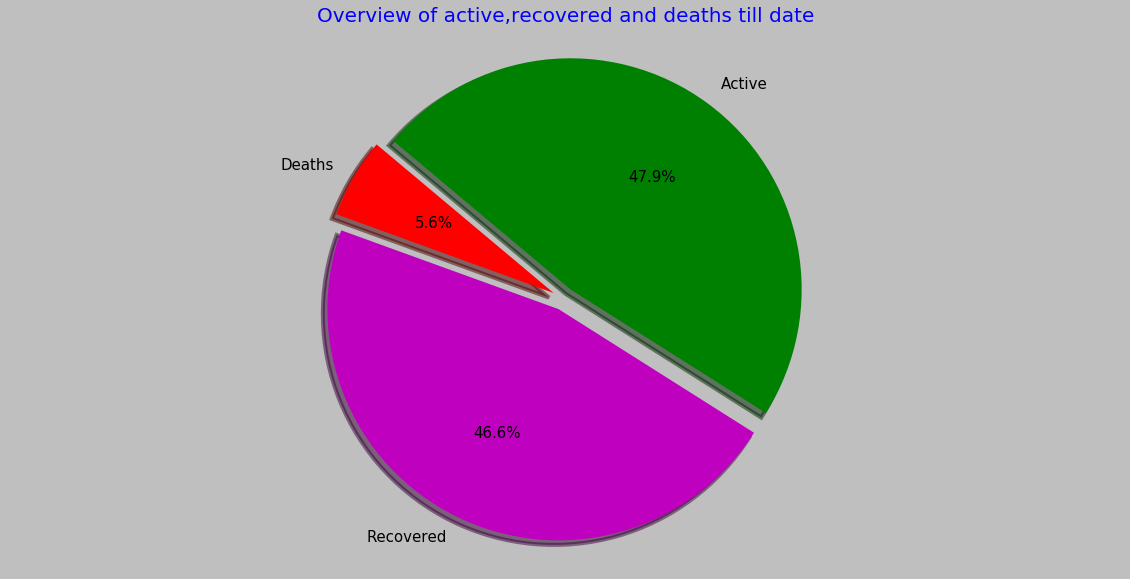

In [284]:
size=Total['Values'][1:]
label=Total['Variable'][1:]
color=['r','m','g']
plt.figure(figsize=(20,10))
plt.pie(size, explode=[0.05,0.05,0.05], labels=label,colors=color,
autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': 15},wedgeprops={'linewidth': 4})
plt.title('Overview of active,recovered and deaths till date',fontsize=20,color='b')
plt.axis('equal')
plt.show()


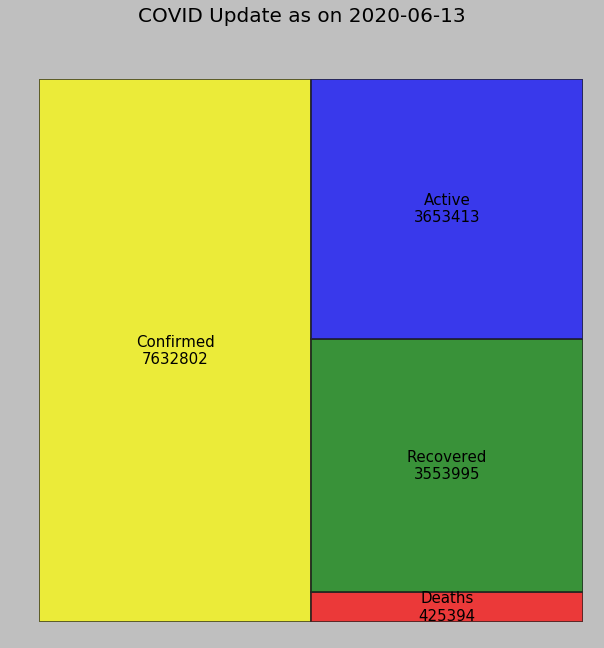

In [285]:
!pip install squarify
import squarify
labels=[]
for i,j in zip(Total['Variable'],Total['Values']):
    k=str(i)+'\n'+str(j)
    labels.append(k)
fig = plt.figure(figsize=(10, 10))
fig.suptitle('COVID Update as on '+str(date.today()), fontsize=20)
ax = fig.add_subplot(111, aspect="equal")
ax=squarify.plot(sizes=Total['Values'], label=labels,
              color=['yellow','red','green','blue'], alpha=0.7, bar_kwargs=dict(linewidth=2, edgecolor="#222222"))
plt.axis('off')
plt.rc('font', size=15)
plt.show()


<Figure size 1080x2160 with 0 Axes>

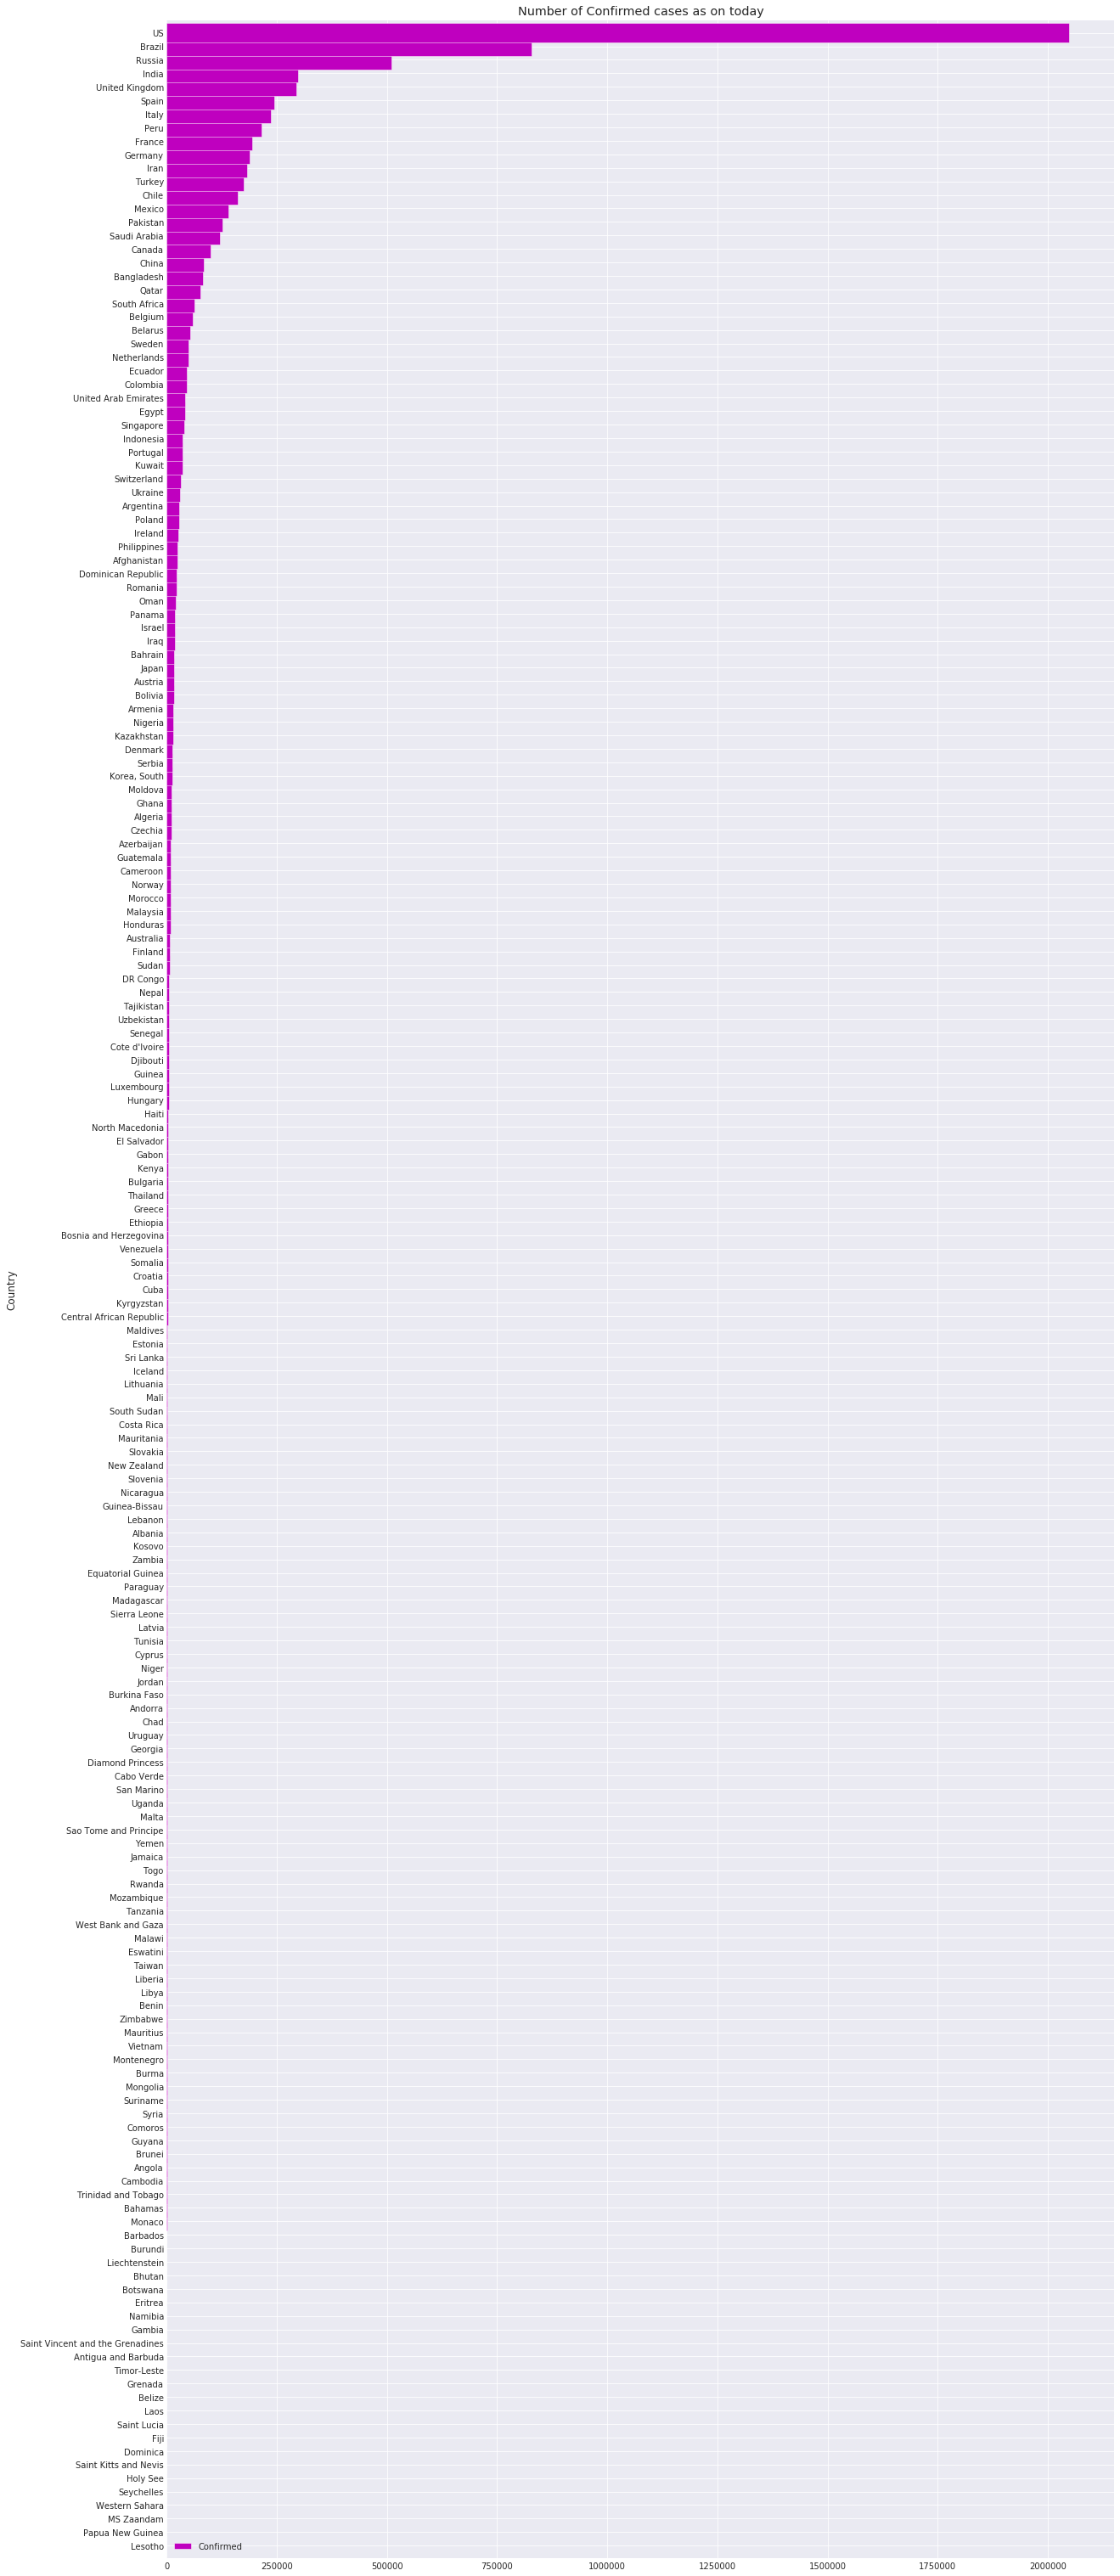

In [480]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15,30))
Data_recent=Data_recent.sort_values(by=['Confirmed'])

Data_recent.plot.barh( x="Country",y="Confirmed",width=1.4,figsize=(20,55),color='m',edgecolor='white',title="Number of Confirmed cases as on today");
plt.show()

US with highest number of Covid cases and India in 7th position as on Jun 1st 2020

Removing countries with 0 confirmed cases from our dataset as these can be considered as unaffected countries


In [290]:
least_affected=Data_recent[Data_recent['Confirmed']<10000]['Country'] ##

In [291]:
print(least_affected.values)

['Lesotho' 'Papua New Guinea' 'MS Zaandam' 'Western Sahara' 'Seychelles'
 'Holy See' 'Saint Kitts and Nevis' 'Dominica' 'Fiji' 'Saint Lucia' 'Laos'
 'Belize' 'Grenada' 'Timor-Leste' 'Antigua and Barbuda'
 'Saint Vincent and the Grenadines' 'Gambia' 'Namibia' 'Eritrea'
 'Botswana' 'Bhutan' 'Liechtenstein' 'Burundi' 'Barbados' 'Monaco'
 'Bahamas' 'Trinidad and Tobago' 'Cambodia' 'Angola' 'Brunei' 'Guyana'
 'Comoros' 'Syria' 'Suriname' 'Mongolia' 'Burma' 'Montenegro' 'Vietnam'
 'Mauritius' 'Zimbabwe' 'Benin' 'Libya' 'Liberia' 'Taiwan' 'Eswatini'
 'Malawi' 'West Bank and Gaza' 'Tanzania' 'Mozambique' 'Rwanda' 'Togo'
 'Jamaica' 'Yemen' 'Sao Tome and Principe' 'Malta' 'Uganda' 'San Marino'
 'Cabo Verde' 'Diamond Princess' 'Georgia' 'Uruguay' 'Chad' 'Andorra'
 'Burkina Faso' 'Jordan' 'Niger' 'Cyprus' 'Tunisia' 'Latvia'
 'Sierra Leone' 'Madagascar' 'Paraguay' 'Equatorial Guinea' 'Zambia'
 'Kosovo' 'Albania' 'Lebanon' 'Guinea-Bissau' 'Nicaragua' 'Slovenia'
 'New Zealand' 'Slovakia' 'Mauritania'

In [292]:
Data_recent.shape

(187, 10)

In [293]:
import matplotlib.colors as mcolors
def composition_cases(Data,typ):
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle('COVID '+str(typ)+' cases as on '+str(date.today()), fontsize=20)
    ax = fig.add_subplot(111, aspect="equal")
   
    Data = Data[Data[typ]>0]
    labels=[]
    for i,j in zip(Data['Country'],Data[typ]):
        k=str(i)+'\n'+str(j)
        labels.append(k)
    ax=squarify.plot(sizes=Data[typ], label=labels,color=mcolors.CSS4_COLORS , alpha=0.7, bar_kwargs=dict(linewidth=2, edgecolor="#222222"))
    plt.axis('off')
    plt.rc('font', size=10)
    plt.show()
    plt.tight_layout()


In [294]:
def composition_case_top20(Data,typ):
    fig = plt.figure(figsize=(16, 16))
    fig.suptitle('COVID '+str(typ)+' top 20 countries as on '+str(date.today()), fontsize=20)
    ax = fig.add_subplot(111, aspect="equal")
   
    Data = Data[Data[typ]>0]
    Data = Data.sort_values(typ).tail(20)
    labels=[]
    for i,j in zip(Data['Country'],Data[typ]):
        k=str(i)+'\n'+str(j)
        labels.append(k)
    ax=squarify.plot(sizes=Data[typ], label=labels,color=mcolors.CSS4_COLORS , alpha=0.7, bar_kwargs=dict(linewidth=2, edgecolor="#222222"))
    plt.axis('off')
    plt.rc('font', size=10)
    plt.show()
    plt.tight_layout()


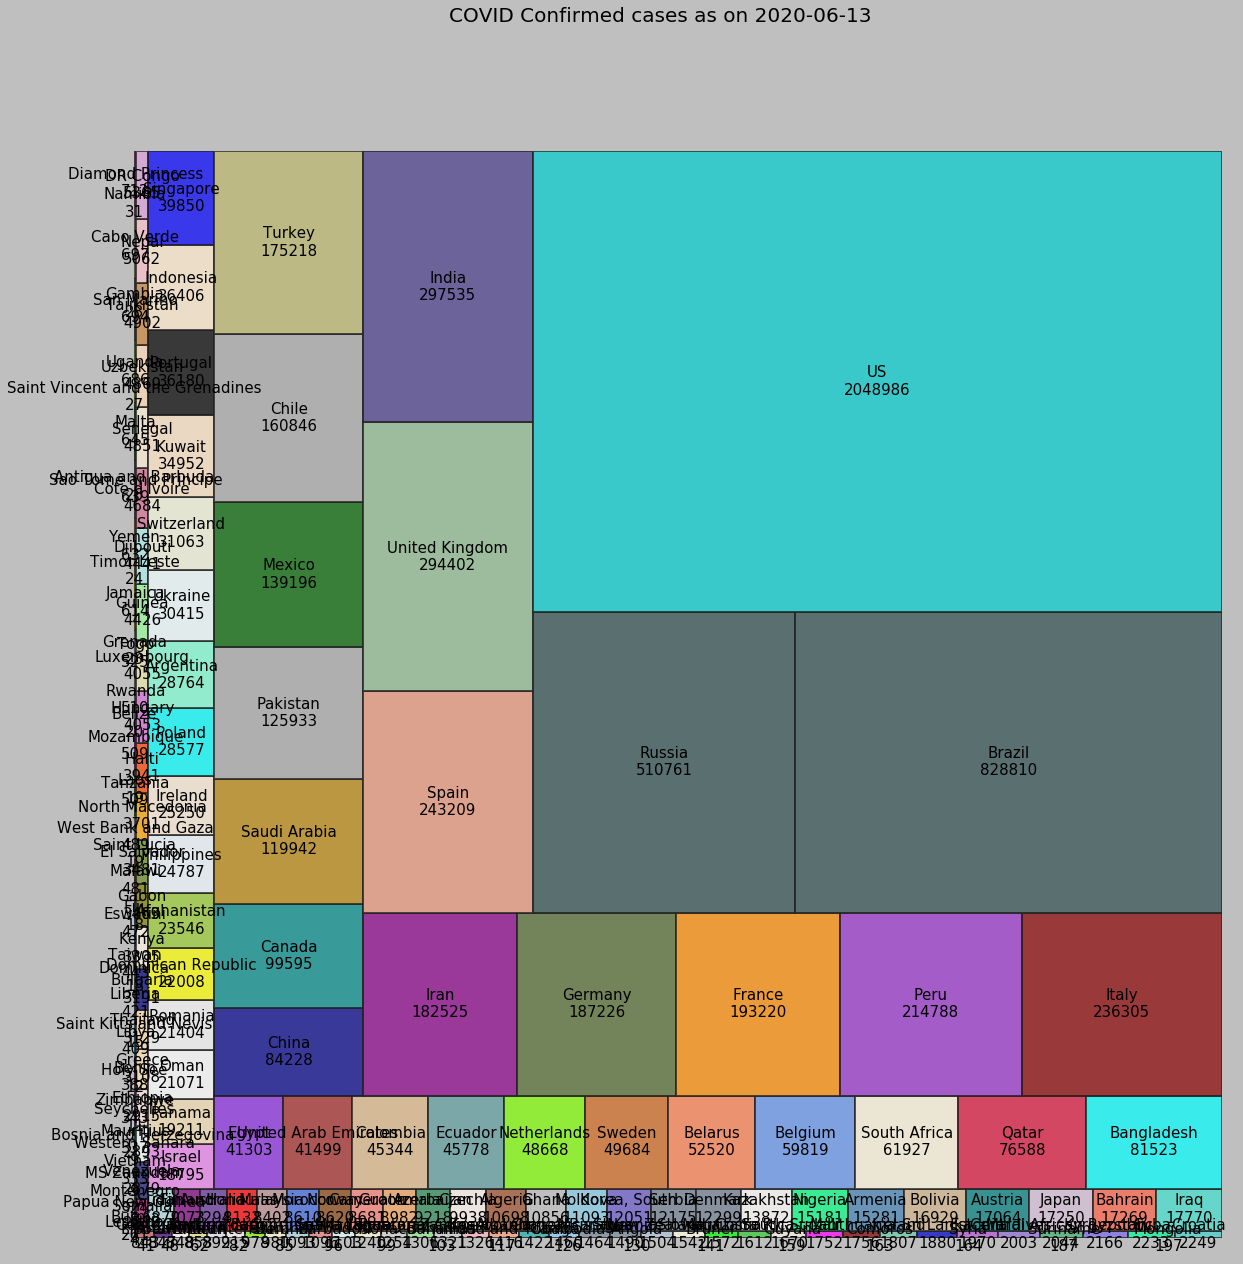

<Figure size 432x288 with 0 Axes>

In [295]:
composition_cases(Data_recent,'Confirmed')

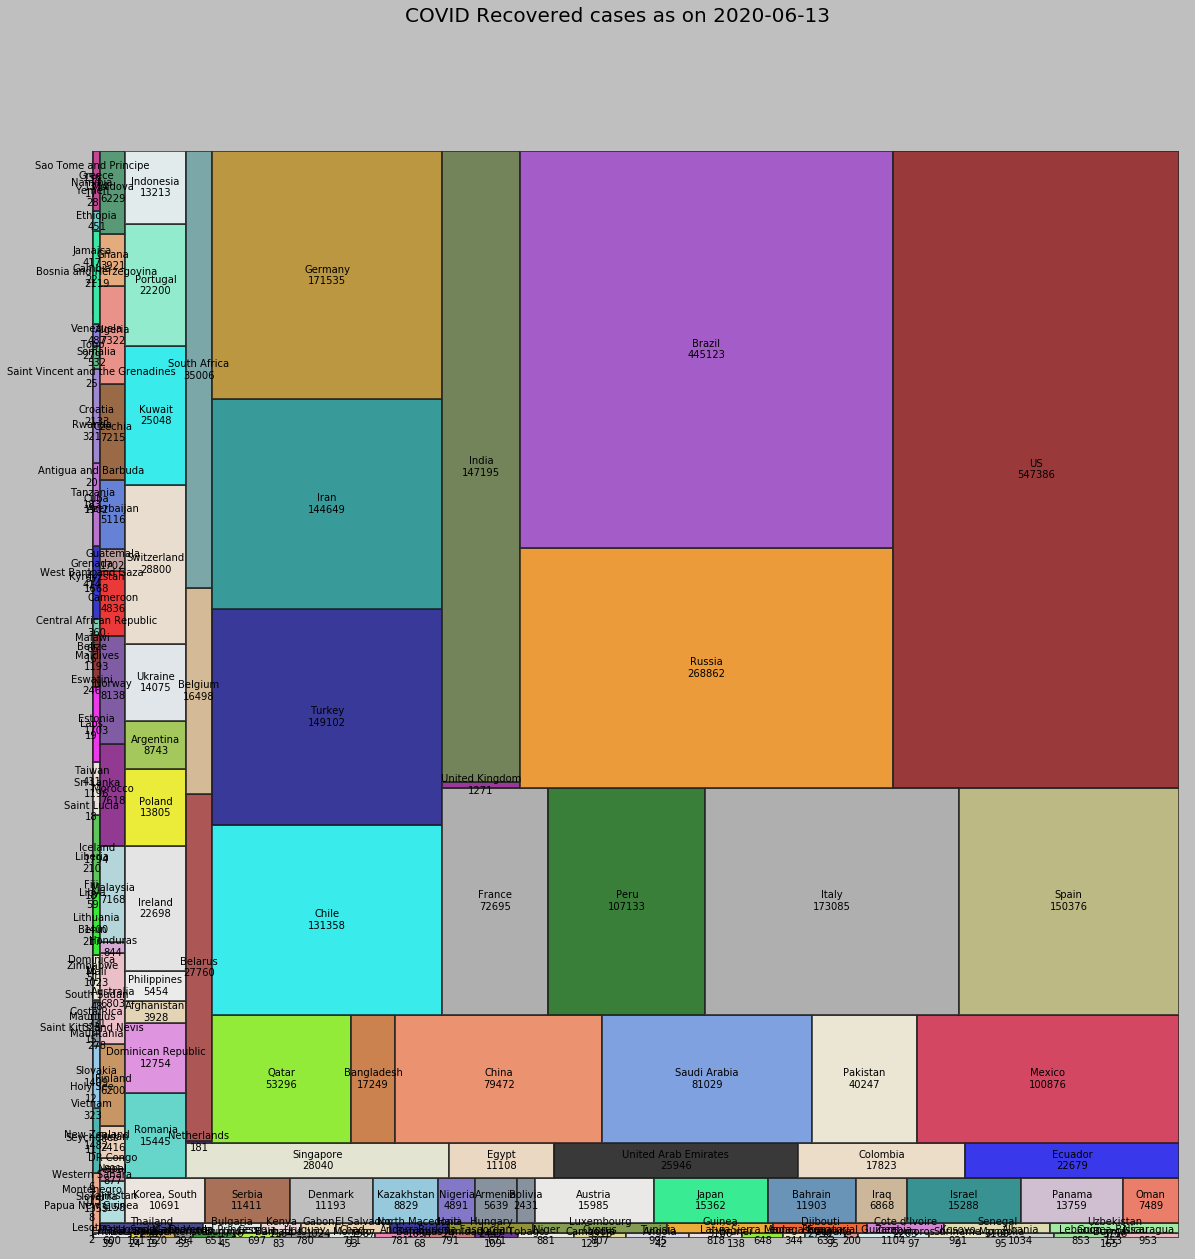

<Figure size 432x288 with 0 Axes>

In [296]:
composition_cases(Data_recent,'Recovered')

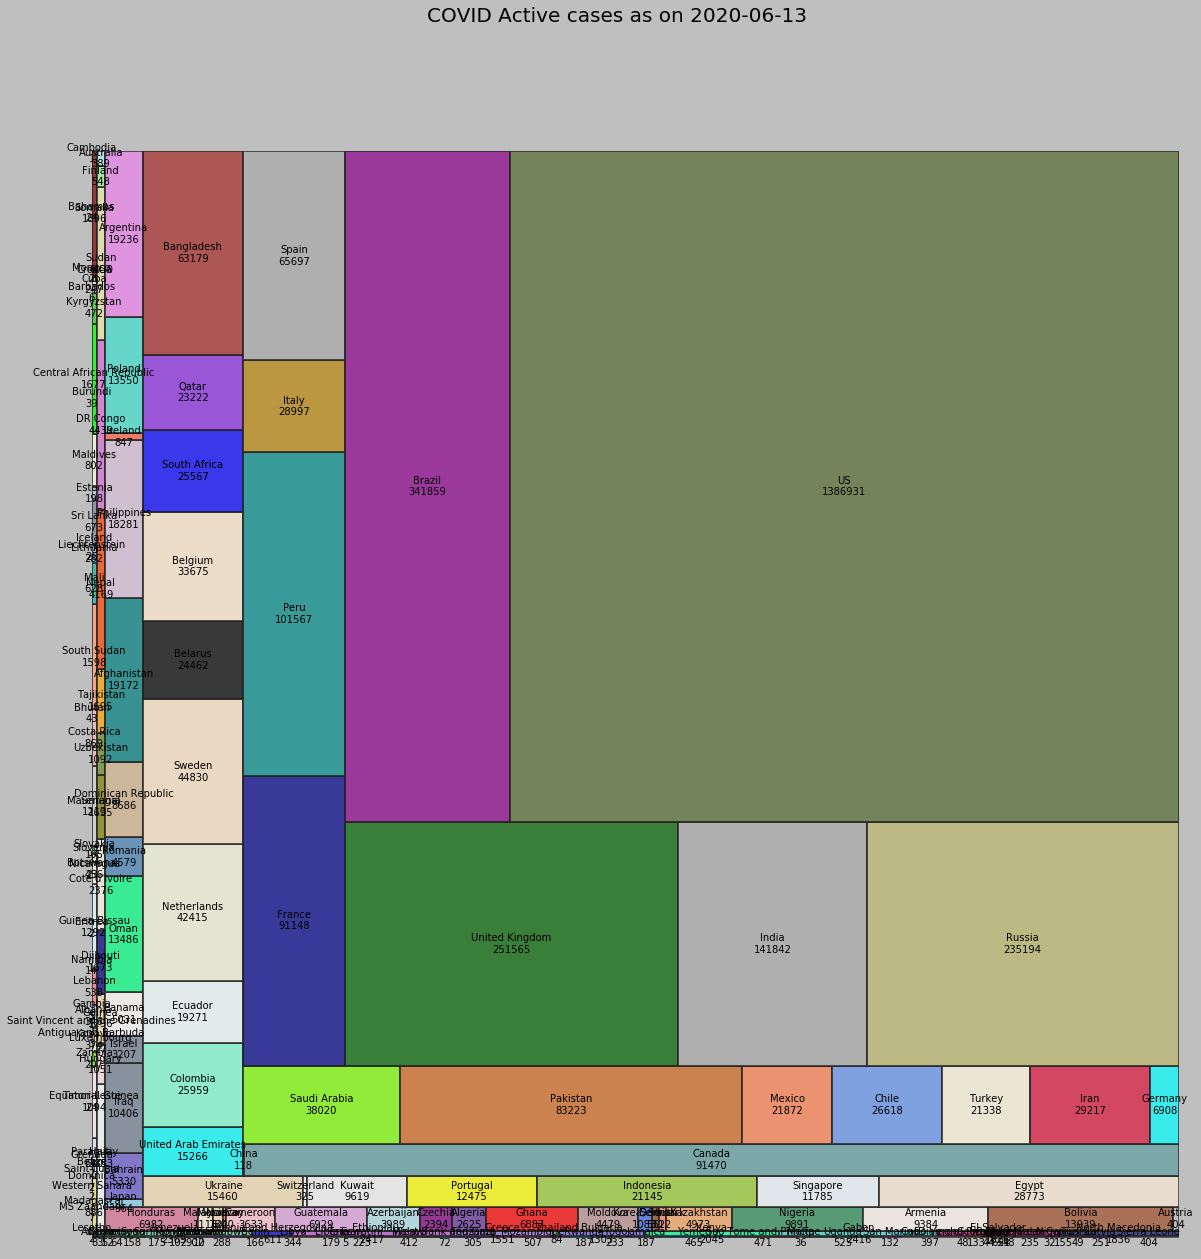

<Figure size 432x288 with 0 Axes>

In [297]:
composition_cases(Data_recent,'Active')

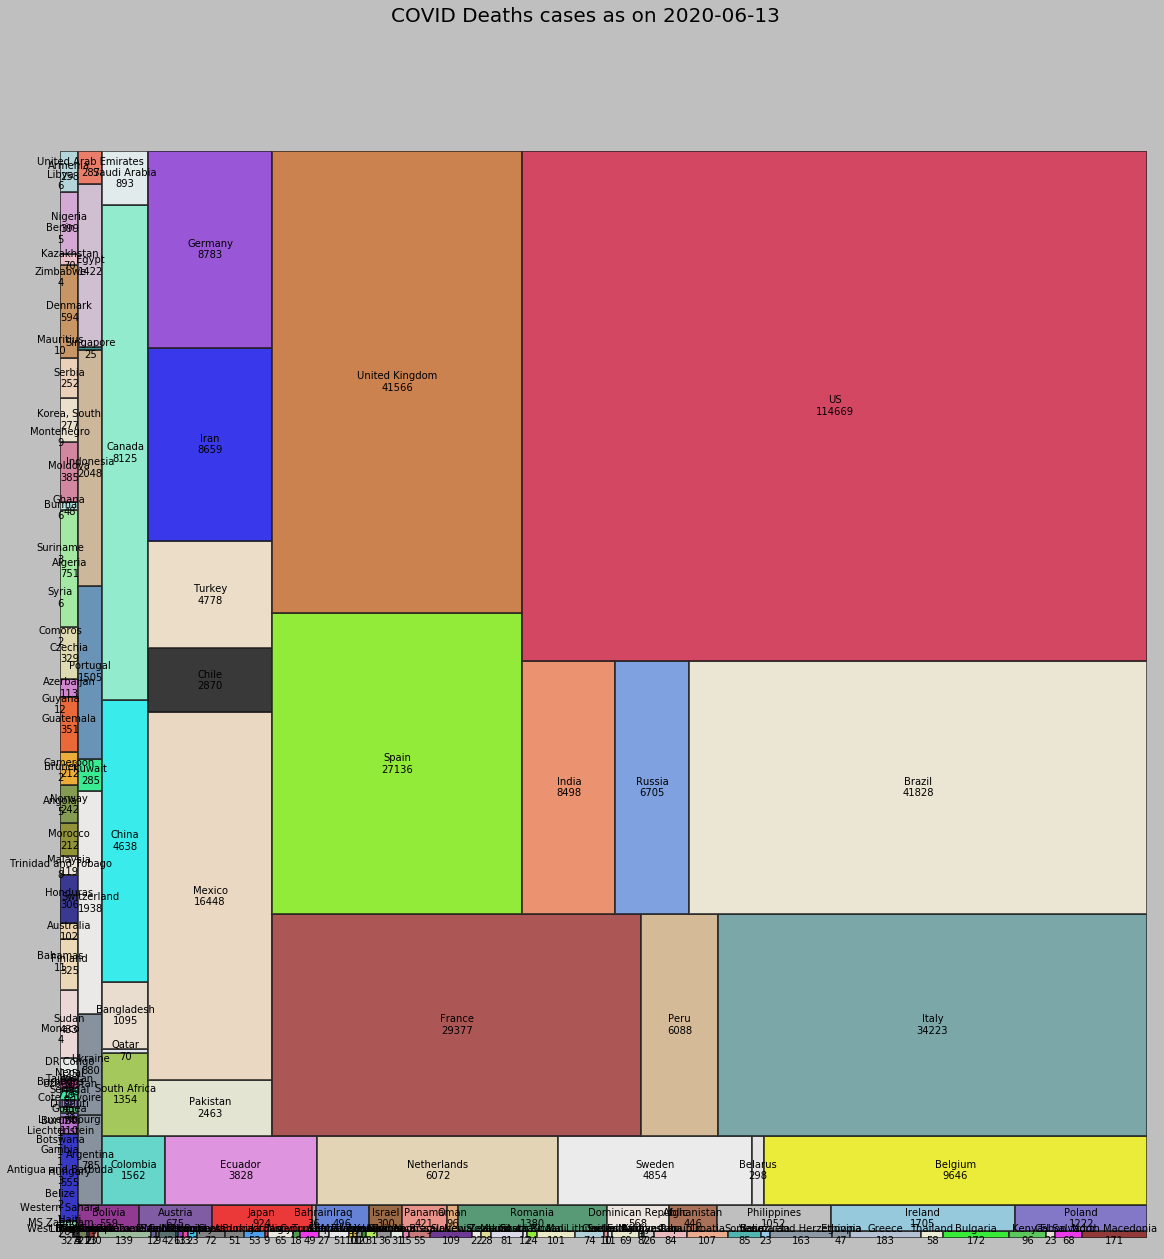

<Figure size 432x288 with 0 Axes>

In [298]:
composition_cases(Data_recent,'Deaths')

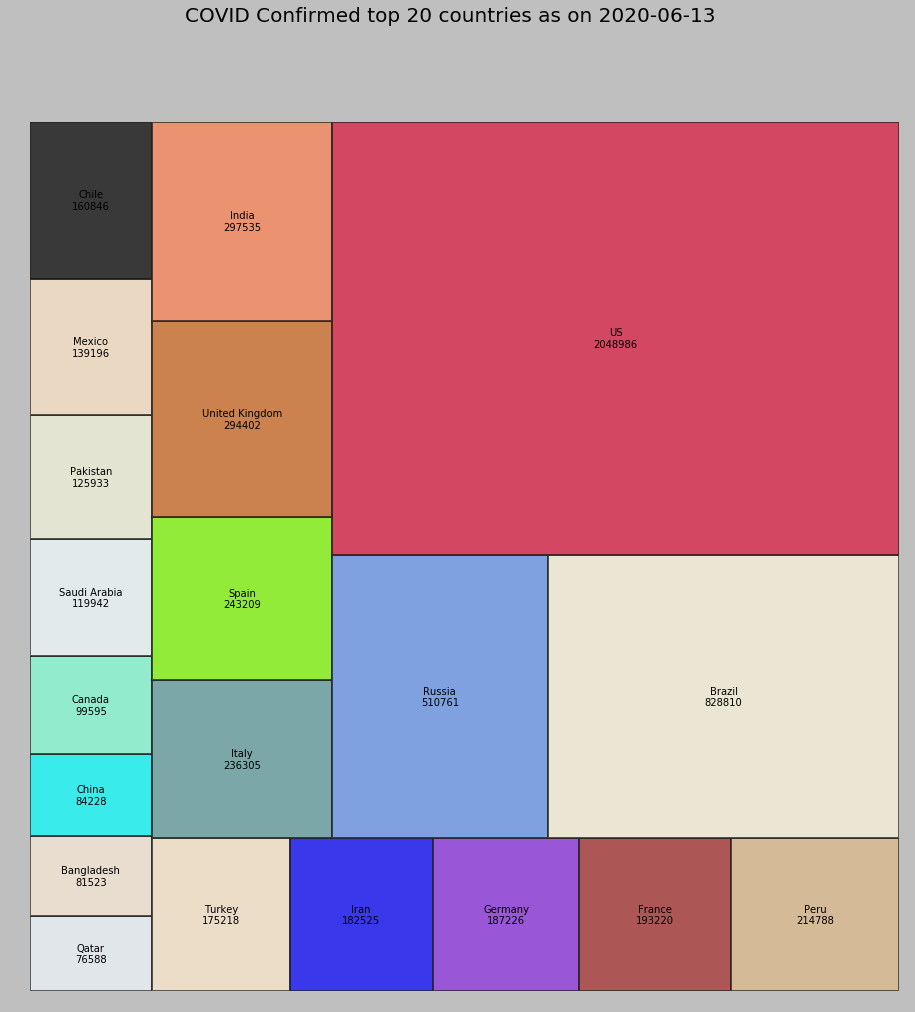

<Figure size 432x288 with 0 Axes>

In [299]:
composition_case_top20(Data_recent,'Confirmed')

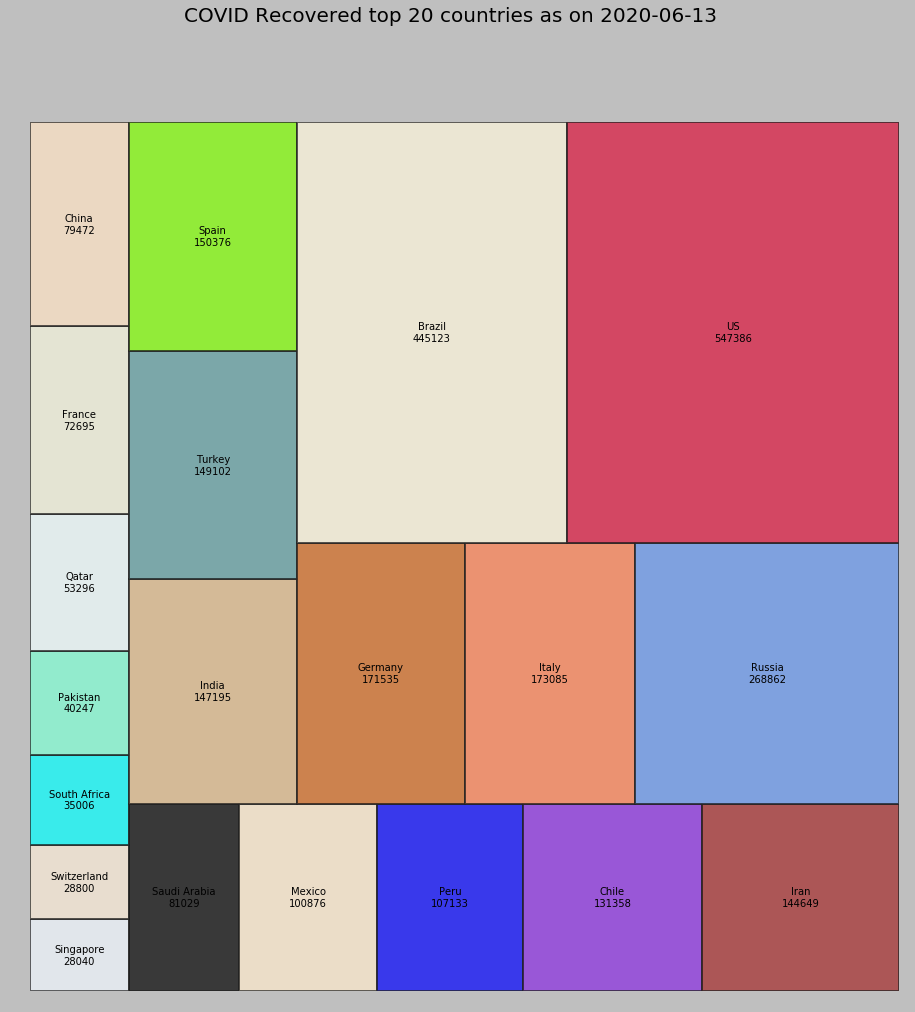

<Figure size 432x288 with 0 Axes>

In [300]:
composition_case_top20(Data_recent,'Recovered')

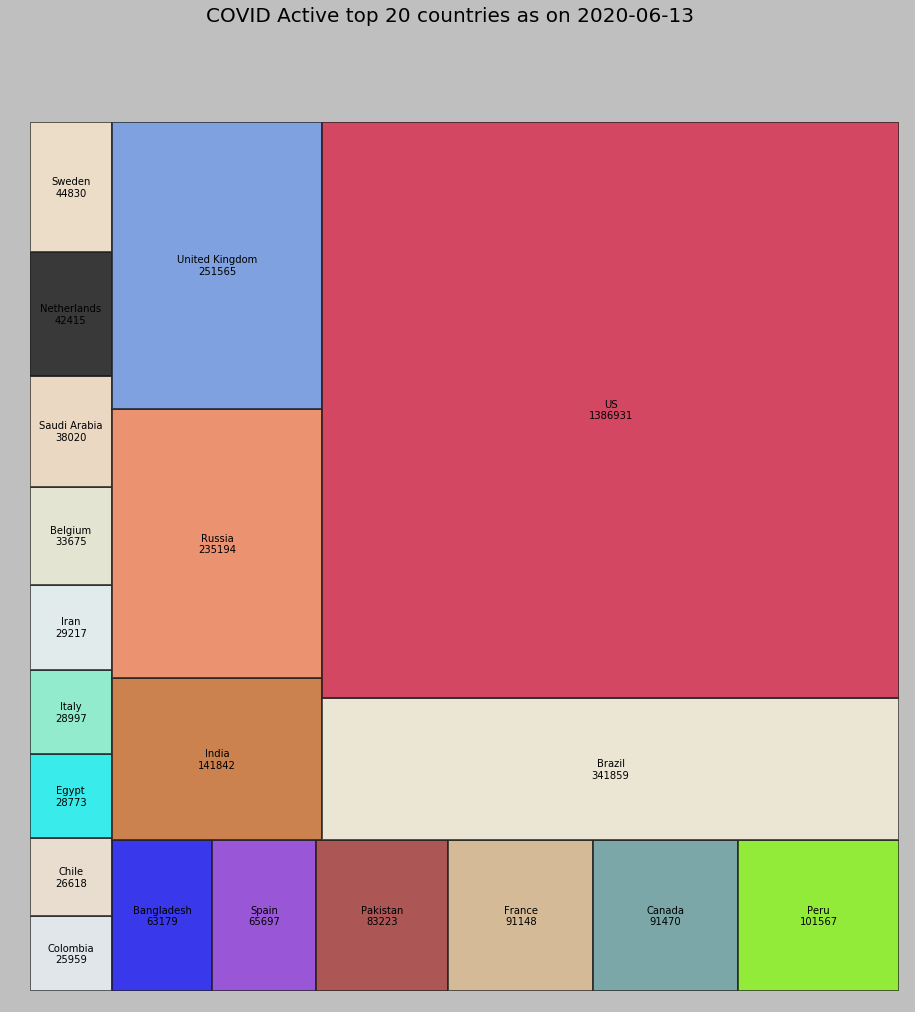

<Figure size 432x288 with 0 Axes>

In [301]:
composition_case_top20(Data_recent,'Active')

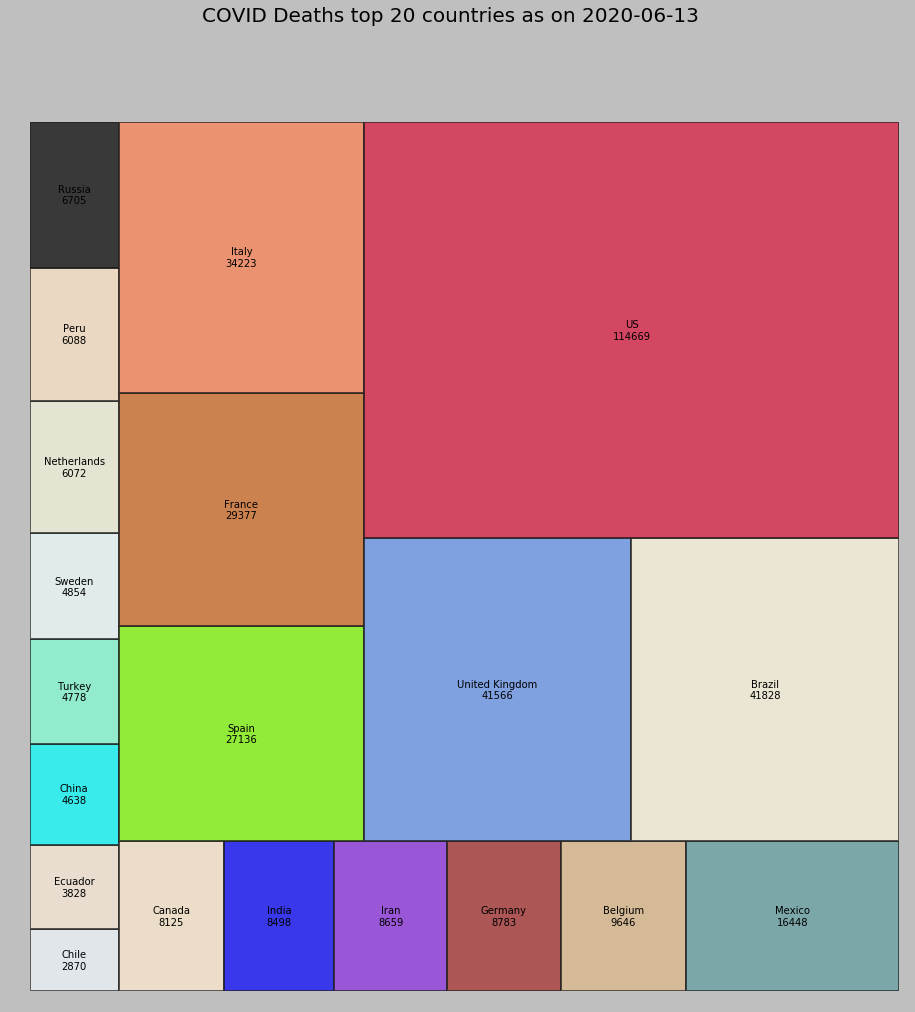

<Figure size 432x288 with 0 Axes>

In [302]:
composition_case_top20(Data_recent,'Deaths')

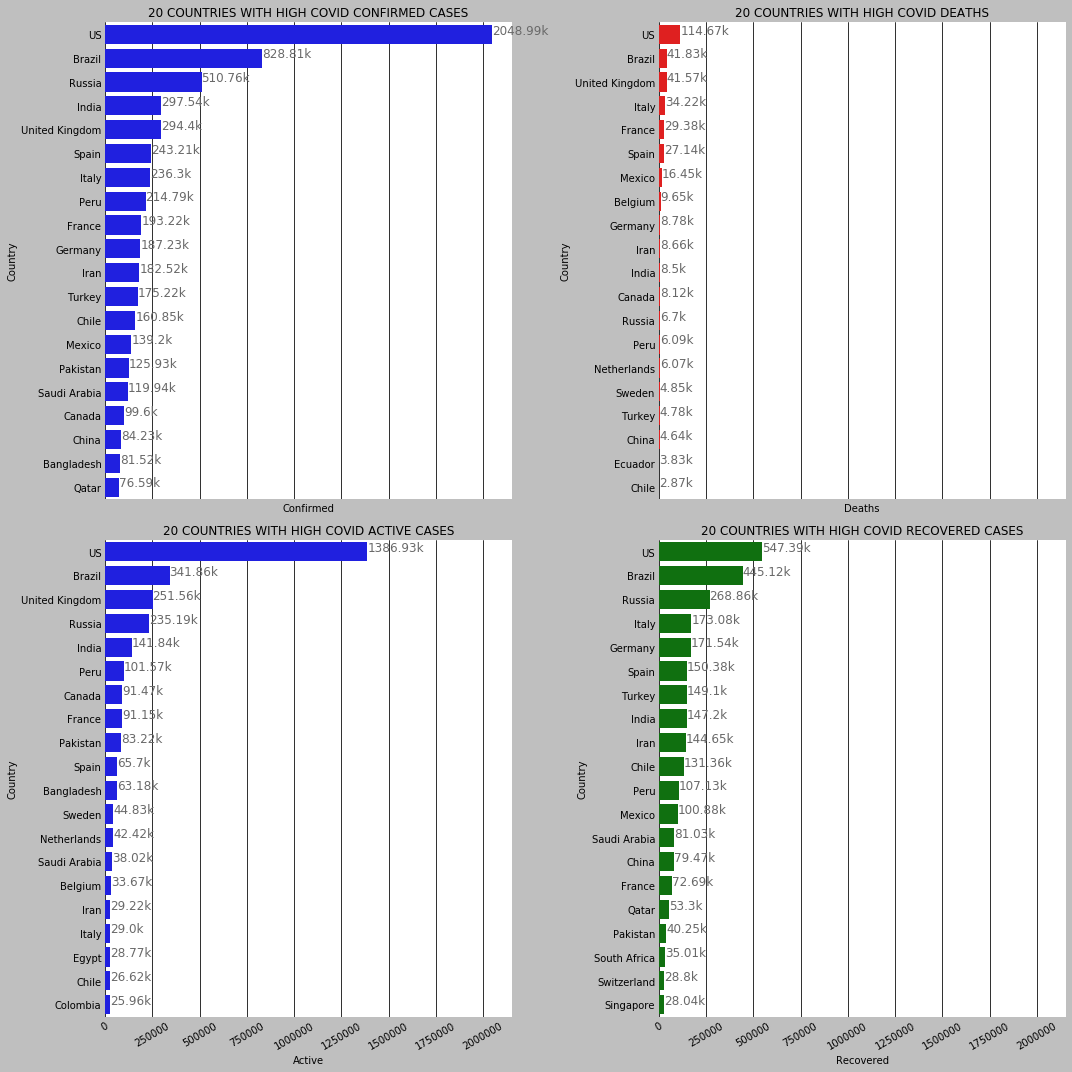

In [304]:
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)

ax1=sns.barplot(x='Confirmed',y='Country',data= Data_recent.sort_values(by=['Confirmed'],ascending=False).head(20),color='blue',ax=axes[0, 0])
plt.setp(axes[0,0].get_xticklabels(),visible=True, rotation=30)
ax1.set_title("20 COUNTRIES WITH HIGH COVID CONFIRMED CASES")
total_c=[]

for i in ax1.patches:
    ax1.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')

ax2=sns.barplot(x='Deaths',y='Country',data= Data_recent.sort_values(by=['Deaths'],ascending=False).head(20),color='red',ax=axes[0, 1])
plt.setp(axes[0,1].get_xticklabels(), rotation=30)
ax2.set_title("20 COUNTRIES WITH HIGH COVID DEATHS")
total_c=[]

for i in ax2.patches:
    ax2.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax3=sns.barplot(x='Active',y='Country',data= Data_recent.sort_values(by=['Active'],ascending=False).head(20),color='blue',ax=axes[1, 0])
plt.setp(axes[1,0].get_xticklabels(), rotation=30)
ax3.set_title("20 COUNTRIES WITH HIGH COVID ACTIVE CASES")
total_c=[]
#for i in ax3.patches:
#    total_c.append(i.get_width())
for i in ax3.patches:
    ax3.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax4=sns.barplot(x='Recovered',y='Country',data= Data_recent.sort_values(by=['Recovered'],ascending=False).head(20),color='green',ax=axes[1, 1])
plt.setp(axes[1,1].get_xticklabels(), rotation=30)

for i in ax4.patches:
    ax4.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax4.set_title("20 COUNTRIES WITH HIGH COVID RECOVERED CASES")
plt.tight_layout()

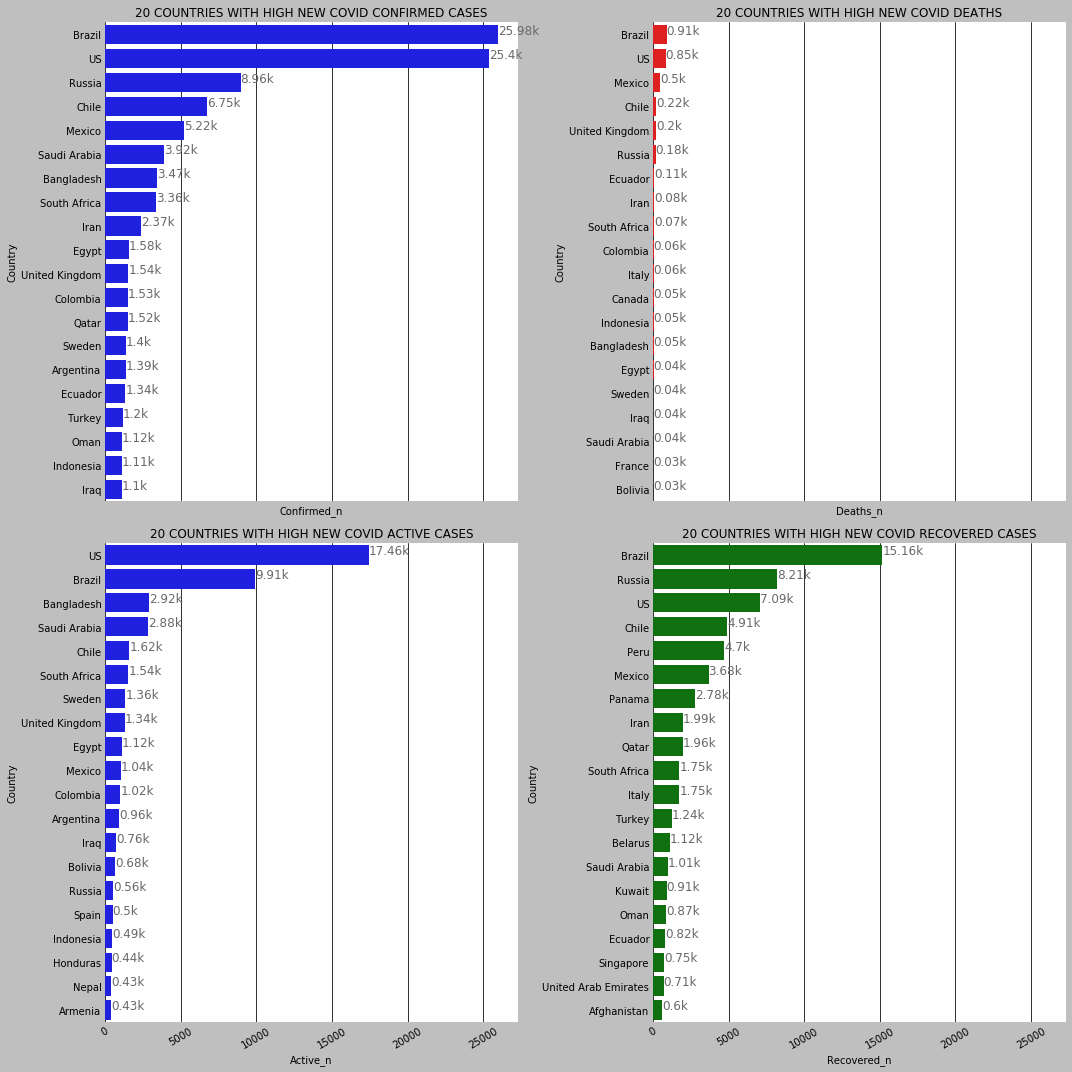

In [306]:
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)

ax1=sns.barplot(x='Confirmed_n',y='Country',data= Data_recent.sort_values(by=['Confirmed_n'],ascending=False).head(20),color='blue',ax=axes[0, 0])
plt.setp(axes[0,0].get_xticklabels(),visible=True, rotation=30)
ax1.set_title("20 COUNTRIES WITH HIGH NEW COVID CONFIRMED CASES")
total_c=[]

for i in ax1.patches:
    ax1.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')

ax2=sns.barplot(x='Deaths_n',y='Country',data= Data_recent.sort_values(by=['Deaths_n'],ascending=False).head(20),color='red',ax=axes[0, 1])
plt.setp(axes[0,1].get_xticklabels(), rotation=30)
ax2.set_title("20 COUNTRIES WITH HIGH NEW COVID DEATHS")
total_c=[]

for i in ax2.patches:
    ax2.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax3=sns.barplot(x='Active_n',y='Country',data= Data_recent.sort_values(by=['Active_n'],ascending=False).head(20),color='blue',ax=axes[1, 0])
plt.setp(axes[1,0].get_xticklabels(), rotation=30)
ax3.set_title("20 COUNTRIES WITH HIGH NEW COVID ACTIVE CASES")
total_c=[]
#for i in ax3.patches:
#    total_c.append(i.get_width())
for i in ax3.patches:
    ax3.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax4=sns.barplot(x='Recovered_n',y='Country',data= Data_recent.sort_values(by=['Recovered_n'],ascending=False).head(20),color='green',ax=axes[1, 1])
plt.setp(axes[1,1].get_xticklabels(), rotation=30)

for i in ax4.patches:
    ax4.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax4.set_title("20 COUNTRIES WITH HIGH NEW COVID RECOVERED CASES")
plt.tight_layout()

In [307]:
Data_recent[Data_recent['Country']=='US']

Date Country  Confirmed  Deaths  Recovered   Active  Confirmed_n  \
26727 2020-06-12      US    2048986  114669     547386  1386931      25396.0   

       Active_n  Deaths_n  Recovered_n  
26727   17456.0     846.0       7094.0

In [308]:
Data_recent['Deathrate']= round(Data_recent['Deaths']/Data_recent['Confirmed']*100,2)
Data_recent['Recoveryrate']= round(Data_recent['Recovered']/Data_recent['Confirmed']*100,2)
Data_recent.sort_values(by=['Confirmed'],ascending=False,inplace=True)
Data_recent.head()

Date         Country  Confirmed  Deaths  Recovered   Active  \
26727 2020-06-12              US    2048986  114669     547386  1386931   
26577 2020-06-12          Brazil     828810   41828     445123   341859   
26693 2020-06-12          Russia     510761    6705     268862   235194   
26632 2020-06-12           India     297535    8498     147195   141842   
26731 2020-06-12  United Kingdom     294402   41566       1271   251565   

       Confirmed_n  Active_n  Deaths_n  Recovered_n  Deathrate  Recoveryrate  
26727      25396.0   17456.0     846.0       7094.0       5.60         26.71  
26577      25982.0    9915.0     909.0      15158.0       5.05         53.71  
26693       8961.0     565.0     183.0       8213.0       1.31         52.64  
26632          0.0       0.0       0.0          0.0       2.86         49.47  
26731       1542.0    1336.0     202.0          4.0      14.12          0.43

In [309]:
Most_affected=Data_recent[Data_recent['Confirmed']>100000]

In [310]:

print(Most_affected.shape)
Most_affected

(16, 12)


Date         Country  Confirmed  Deaths  Recovered   Active  \
26727 2020-06-12              US    2048986  114669     547386  1386931   
26577 2020-06-12          Brazil     828810   41828     445123   341859   
26693 2020-06-12          Russia     510761    6705     268862   235194   
26632 2020-06-12           India     297535    8498     147195   141842   
26731 2020-06-12  United Kingdom     294402   41566       1271   251565   
26711 2020-06-12           Spain     243209   27136     150376    65697   
26638 2020-06-12           Italy     236305   34223     173085    28997   
26687 2020-06-12            Peru     214788    6088     107133   101567   
26615 2020-06-12          France     193220   29377      72695    91148   
26619 2020-06-12         Germany     187226    8783     171535     6908   
26634 2020-06-12            Iran     182525    8659     144649    29217   
26726 2020-06-12          Turkey     175218    4778     149102    21338   
26589 2020-06-12           Chile     160846    2870     131358    26618   
26666 2020-06-12          Mexico     139196   16448     100876    21872   
26683 2020-06-12        Pakistan     125933    2463      40247    83223   
26700 2020-06-12    Saudi Arabia     119942     893      81029    38020   

       Confirmed_n  Active_n  Deaths_n  Recovered_n  Deathrate  Recoveryrate  
26727      25396.0   17456.0     846.0       7094.0       5.60         26.71  
26577      25982.0    9915.0     909.0      15158.0       5.05         53.71  
26693       8961.0     565.0     183.0       8213.0       1.31         52.64  
26632          0.0       0.0       0.0          0.0       2.86         49.47  
26731       1542.0    1336.0     202.0          4.0      14.12          0.43  
26711        502.0     502.0       0.0          0.0      11.16         61.83  
26638        163.0   -1640.0      56.0       1747.0      14.48         73.25  
26687          0.0   -4704.0       0.0       4704.0       2.83         49.88  
26615        727.0     273.0      28.0        426.0      15.20         37.62  
26619        535.0     -50.0      11.0        574.0       4.69         91.62  
26634       2369.0     308.0      75.0       1986.0       4.74         79.25  
26726       1195.0     -62.0      15.0       1242.0       2.73         85.10  
26589       6754.0    1618.0     222.0       4914.0       1.78         81.67  
26666       5222.0    1040.0     504.0       3678.0      11.82         72.47  
26683          0.0       0.0       0.0          0.0       1.96         31.96  
26700       3921.0    2875.0      36.0       1010.0       0.74         67.56

13 countries with more than one lakh affected cases are found. furthur analysis on these countries would be done

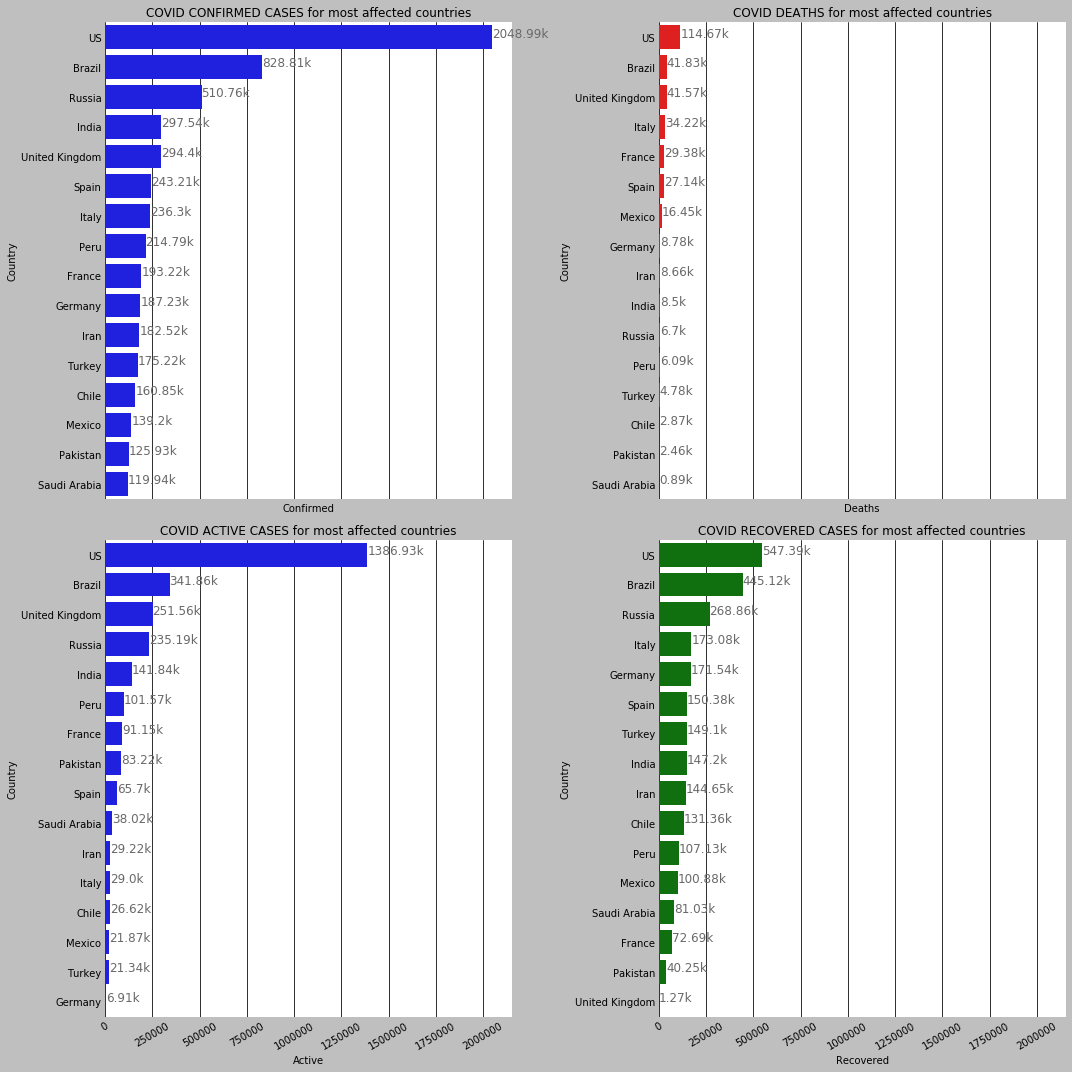

In [311]:
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)

ax1=sns.barplot(x='Confirmed',y='Country',data= Most_affected.sort_values(by=['Confirmed'],ascending=False),color='blue',ax=axes[0, 0])
plt.setp(axes[0,0].get_xticklabels(),visible=True, rotation=30)
ax1.set_title("COVID CONFIRMED CASES for most affected countries")
total_c=[]

for i in ax1.patches:
    ax1.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')

ax2=sns.barplot(x='Deaths',y='Country',data= Most_affected.sort_values(by=['Deaths'],ascending=False),color='red',ax=axes[0, 1])
plt.setp(axes[0,1].get_xticklabels(), rotation=30)
ax2.set_title("COVID DEATHS for most affected countries")
total_c=[]

for i in ax2.patches:
    ax2.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax3=sns.barplot(x='Active',y='Country',data= Most_affected.sort_values(by=['Active'],ascending=False),color='blue',ax=axes[1, 0])
plt.setp(axes[1,0].get_xticklabels(), rotation=30)
ax3.set_title("COVID ACTIVE CASES for most affected countries")
total_c=[]
#for i in ax3.patches:
#    total_c.append(i.get_width())
for i in ax3.patches:
    ax3.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax4=sns.barplot(x='Recovered',y='Country',data= Most_affected.sort_values(by=['Recovered'],ascending=False),color='green',ax=axes[1, 1])
plt.setp(axes[1,1].get_xticklabels(), rotation=30)

for i in ax4.patches:
    ax4.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax4.set_title("COVID RECOVERED CASES for most affected countries")
plt.tight_layout()

In [312]:
Most_affected[Most_affected['Country']=='US']

Date Country  Confirmed  Deaths  Recovered   Active  Confirmed_n  \
26727 2020-06-12      US    2048986  114669     547386  1386931      25396.0   

       Active_n  Deaths_n  Recovered_n  Deathrate  Recoveryrate  
26727   17456.0     846.0       7094.0        5.6         26.71

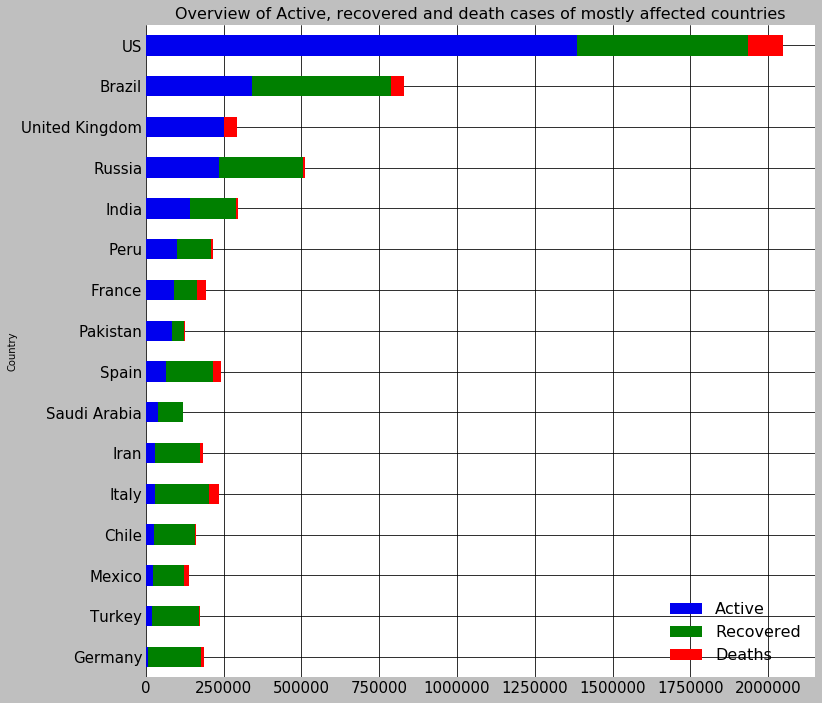

In [313]:

color=['#0000EE','green','red'] 
Most_affected = Most_affected.sort_values(by=['Confirmed'])
x=Most_affected[['Country','Active','Recovered','Deaths']]
y=x.set_index('Country')
z=y.groupby('Country').sum().sort_values(by=['Active'])
f=z.plot.barh(color=color,stacked=True,figsize=(12,12),fontsize=15,title='Overview of Active, recovered and death cases of mostly affected countries')
plt.legend(loc=4, prop={'size': 16})
f.title.set_fontsize(16)

Recovery rate is quite low in some countries.From the plot its evident that Germany has better recovery rate than other most affected countries.lets have a look at death rate and recovery rate in each country.

In [314]:
# Plotting Top 15 countries with best recovery rate and highest death rate 

In [315]:
#f, axes = plt.subplots(1,2,figsize=(15, 15), sharex=True)
r= Data_recent[['Country','Recoveryrate','Confirmed']].sort_values(by=['Recoveryrate']).tail(15)
r

Country  Recoveryrate  Confirmed
26665              Mauritius         96.44        337
26656             Luxembourg         96.62       4055
26735                Vietnam         97.00        333
26670             Montenegro         97.22        324
26718                 Taiwan         97.29        443
26578                 Brunei         97.87        141
26676            New Zealand         98.54       1504
26584               Cambodia         99.21        126
26631                Iceland         99.28       1807
26685       Papua New Guinea        100.00          8
26648                   Laos        100.00         19
26613                   Fiji        100.00         18
26695  Saint Kitts and Nevis        100.00         15
26628               Holy See        100.00         12
26703             Seychelles        100.00         11

In [316]:
#Lowest death rate
d=Data_recent[['Country','Deathrate']].sort_values(by=['Deathrate']).head(15)
d

Country  Deathrate
26651                           Lesotho        0.0
26685                  Papua New Guinea        0.0
26735                           Vietnam        0.0
26584                          Cambodia        0.0
26573                            Bhutan        0.0
26728                            Uganda        0.0
26609                           Eritrea        0.0
26673                           Namibia        0.0
26697  Saint Vincent and the Grenadines        0.0
26722                       Timor-Leste        0.0
26622                           Grenada        0.0
26669                          Mongolia        0.0
26648                              Laos        0.0
26696                       Saint Lucia        0.0
26613                              Fiji        0.0

In [317]:
#Most_affected['Deathrate']= round(Most_affected['Deaths']/Most_affected['Confirmed']*100,2)
#Most_affected['Recoveryrate']= round(Most_affected['Recovered']/Most_affected['Confirmed']*100,2)
Most_affected.sort_values(by=['Confirmed'],ascending=False,inplace=True)
Most_affected.head()



Date         Country  Confirmed  Deaths  Recovered   Active  \
26727 2020-06-12              US    2048986  114669     547386  1386931   
26577 2020-06-12          Brazil     828810   41828     445123   341859   
26693 2020-06-12          Russia     510761    6705     268862   235194   
26632 2020-06-12           India     297535    8498     147195   141842   
26731 2020-06-12  United Kingdom     294402   41566       1271   251565   

       Confirmed_n  Active_n  Deaths_n  Recovered_n  Deathrate  Recoveryrate  
26727      25396.0   17456.0     846.0       7094.0       5.60         26.71  
26577      25982.0    9915.0     909.0      15158.0       5.05         53.71  
26693       8961.0     565.0     183.0       8213.0       1.31         52.64  
26632          0.0       0.0       0.0          0.0       2.86         49.47  
26731       1542.0    1336.0     202.0          4.0      14.12          0.43

Text(0.5, 1.0, 'Recovery rate of most affected countries ')

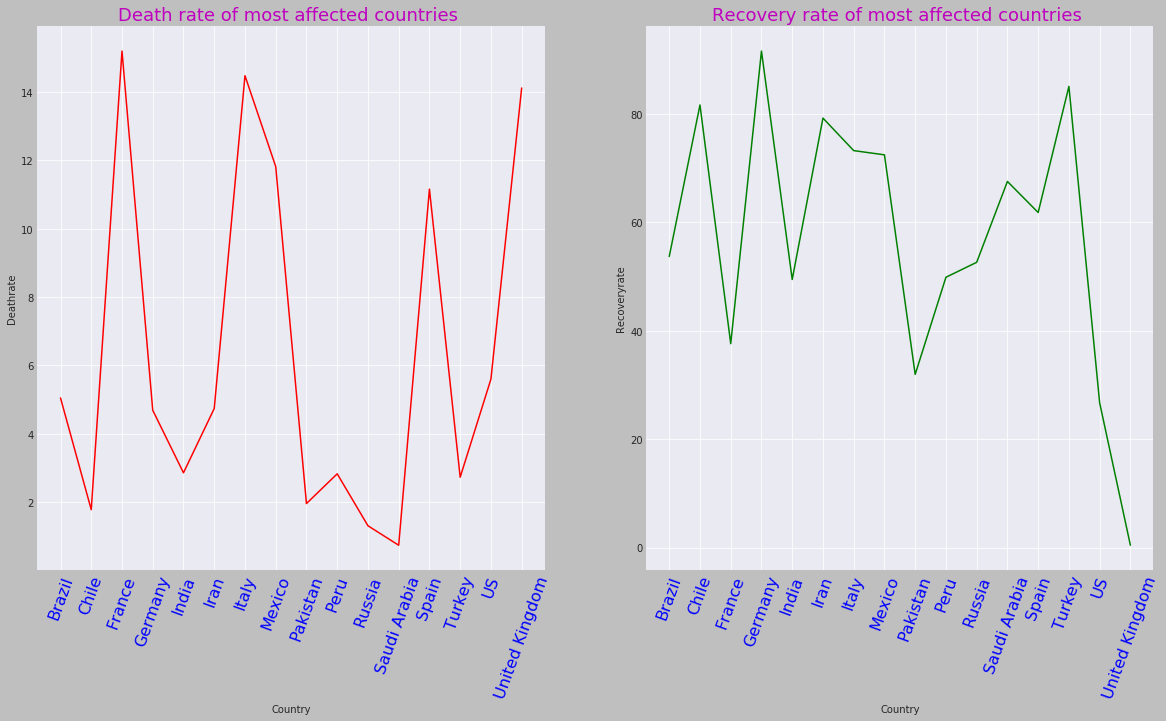

In [318]:
plt.figure(figsize=(20,10))
plt.style.use('seaborn-darkgrid')
plt.subplot(1, 2, 1)
ax1=sns.lineplot(x='Country',y='Deathrate',data=Most_affected,color='red')
ax1.set_title('Death rate of most affected countries ',fontsize=18,color='m')
plt.xticks(fontsize=16,color='blue')
plt.xticks(rotation=70)

plt.subplot(1, 2, 2)
ax2=sns.lineplot(x='Country',y='Recoveryrate',data=Most_affected,color='green')
plt.xticks(rotation=70)
plt.xticks(fontsize=16,color='blue')

ax2.set_title('Recovery rate of most affected countries ',fontsize=18,color='m')

Lets have a look at temporial analysis of covid cases 


188 countries with data from 22 jun 2020 till today

How about temporial analysis of covid cases,what is the trend for most affected countries

In [319]:
timed_data = World_Data.groupby('Date').sum().reset_index()
timed_data['Deathrate']=timed_data['Deaths']/timed_data['Confirmed']*100
timed_data['Activerate']=timed_data['Active']/timed_data['Confirmed']*100
timed_data['Recoveryrate']=timed_data['Recovered']/timed_data['Confirmed']*100
timed_data.head()



Date  Confirmed  Deaths  Recovered  Active  Confirmed_n  Active_n  \
0 2020-01-22        555      17         28     510        555.0     510.0   
1 2020-01-23        654      18         30     606         99.0      96.0   
2 2020-01-24        941      26         36     879        287.0     273.0   
3 2020-01-25       1434      42         39    1353        493.0     474.0   
4 2020-01-26       2118      56         52    2010        684.0     657.0   

   Deaths_n  Recovered_n  Deathrate  Activerate  Recoveryrate  
0      17.0         28.0   3.063063   91.891892      5.045045  
1       1.0          2.0   2.752294   92.660550      4.587156  
2       8.0          6.0   2.763018   93.411265      3.825717  
3      16.0          3.0   2.928870   94.351464      2.719665  
4      14.0         13.0   2.644004   94.900850      2.455146

Text(0.5, 1.0, 'COVID active, recovered and death cases trend all over the world')

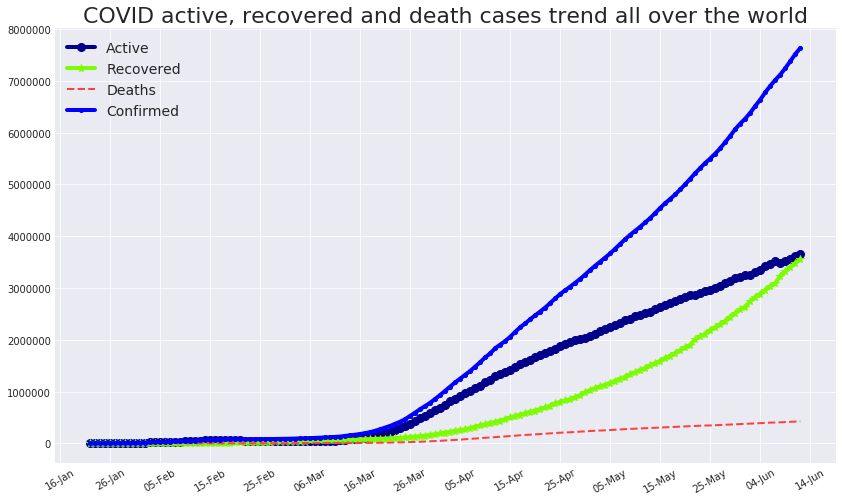

In [320]:
f,ax= plt.subplots(figsize=(14,8))
import matplotlib.ticker as ticker
#plt.figure(figsize=(14,8))
plt.style.use('seaborn-darkgrid')

plt.plot( 'Date','Active', data=timed_data, marker='o', color='#00008B',markersize=8, linewidth=4)
plt.plot( 'Date','Recovered', data=timed_data, marker='*', color='#7CFC00',markersize=8, linewidth=4)
plt.plot('Date','Deaths', data=timed_data, marker=' ', color='#FF4040', markersize=8,linewidth=2, linestyle='dashed')
plt.plot( 'Date','Confirmed', data=timed_data, marker='o', color='blue',markersize=4, linewidth=4)
plt.legend(fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=30)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.title('COVID active, recovered and death cases trend all over the world',fontsize=22)


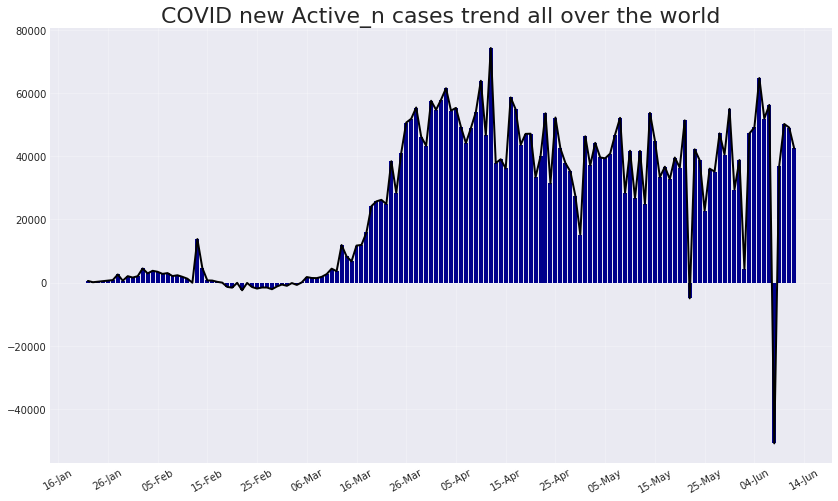

In [321]:

import matplotlib.ticker as ticker
def barplot(data,col,plot_type,color):
#plt.figure(figsize=(14,8))
    f,ax= plt.subplots(figsize=(14,8))
    plt.style.use(plot_type)

    plt.bar( 'Date',col, data=data, color=color, linewidth=4)
    plt.plot('Date',col, data=data, color='black', linewidth=2)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    plt.grid(linewidth=0.5,alpha=0.5)
    plt.title('COVID new '+str(col)+' cases trend all over the world',fontsize=22)
barplot(timed_data,'Active_n','grayscale','#00008B')

In [322]:
#Huge reduction in active cases on 8th june is observed --This is due to missing recovery information in 'Brazil' which shows around 1 lakh recoveries in one day
print(timed_data[timed_data['Date']=='2020-06-08'])
World_Data[(World_Data['Date']=='2020-06-08')&(World_Data['Country']=='Brazil')]

          Date  Confirmed  Deaths  Recovered   Active  Confirmed_n  Active_n  \
138 2020-06-08    7119195  406574    3237837  3474784     103777.0  -50892.0   

     Deaths_n  Recovered_n  Deathrate  Activerate  Recoveryrate  
138    3747.0     150922.0   5.710955   48.808664     45.480381  


Date Country  Confirmed  Deaths  Recovered  Active  Confirmed_n  \
25829 2020-06-08  Brazil     707412   37134     378257  292021      15654.0   

       Active_n  Deaths_n  Recovered_n  
25829  -79330.0     679.0      94305.0

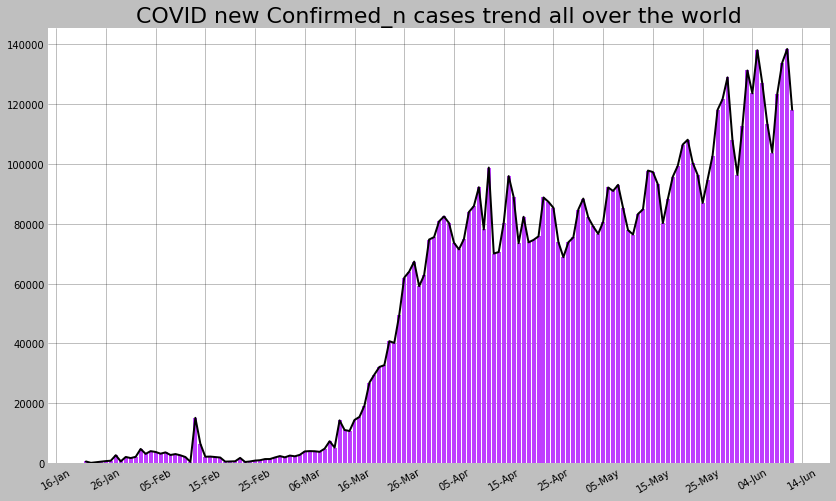

In [323]:
barplot(timed_data,'Confirmed_n','grayscale','#BF3EFF')

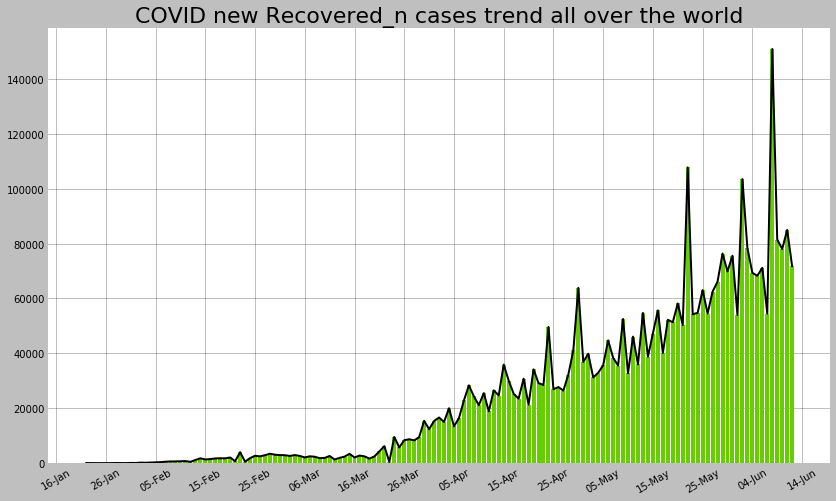

In [324]:
barplot(timed_data,'Recovered_n','grayscale','#66CD00')

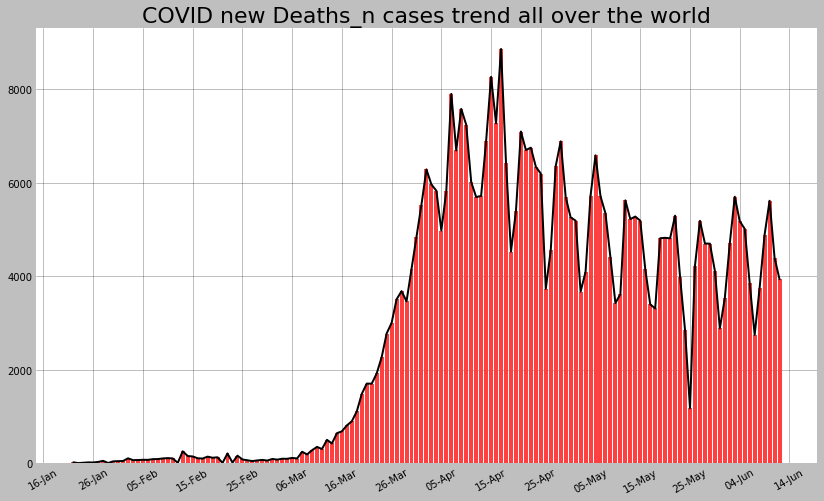

In [325]:
barplot(timed_data,'Deaths_n','grayscale','#FF4040')

Text(0.5, 1.0, 'COVID active, recovered and death rates trend all over the world')

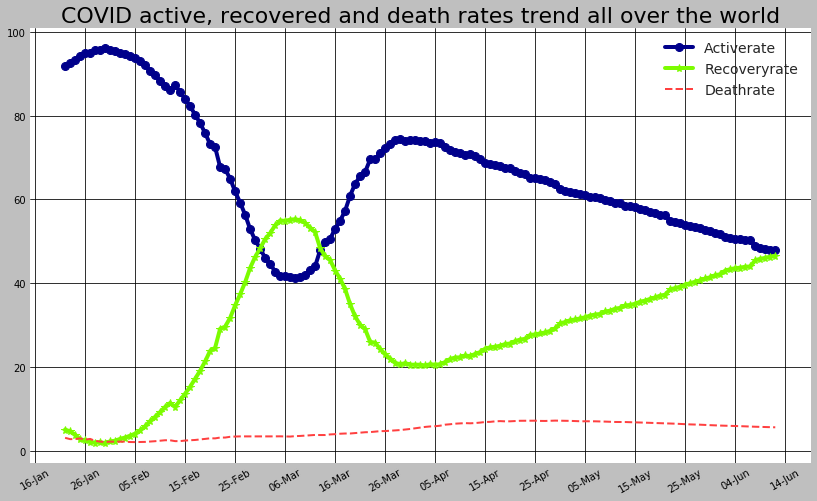

In [326]:
f,ax= plt.subplots(figsize=(14,8))

#plt.figure(figsize=(14,8))
plt.style.use('seaborn-darkgrid')

plt.plot( 'Date','Activerate', data=timed_data, marker='o', color='#00008B',markersize=8, linewidth=4)
plt.plot( 'Date','Recoveryrate', data=timed_data, marker='*', color='#7CFC00',markersize=8, linewidth=4)
plt.plot('Date','Deathrate', data=timed_data, marker=' ', color='#FF4040', markersize=8,linewidth=2, linestyle='dashed')

plt.legend(fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=30)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.title('COVID active, recovered and death rates trend all over the world',fontsize=22)


Active cases rate has its minimum in first week of may with good recovery rate at that time, but active cases raised again till april first week beyond which downward trend is noticed. this might be because of more number of tests done in this period or infection rate raised during this period.

In [327]:
first=timed_data['Date'].min().strftime('%b%d-%Y')

now=date.today().strftime('%b%d-%Y')


In [328]:
Affected=[]
Affected=Most_affected['Country']
Affected.values


array(['US', 'Brazil', 'Russia', 'India', 'United Kingdom', 'Spain',
       'Italy', 'Peru', 'France', 'Germany', 'Iran', 'Turkey', 'Chile',
       'Mexico', 'Pakistan', 'Saudi Arabia'], dtype=object)

In [488]:
df_affected=World_Data[World_Data['Country'].isin(Affected)]
df_affected.shape

(2288, 10)

<Figure size 1440x1080 with 0 Axes>

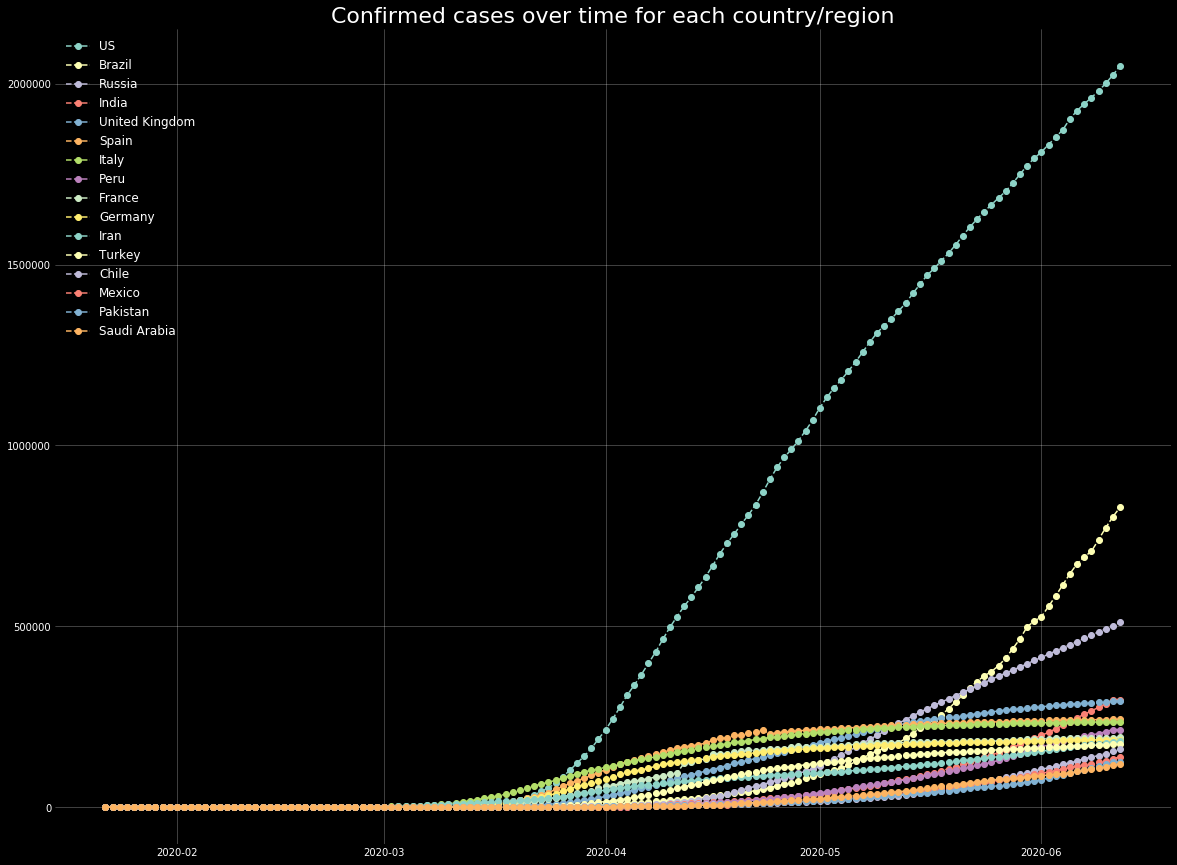

In [489]:
def plot_overtime(df_affected,col,plot_style):
    plt.style.use(plot_style)
    plt.figure(figsize=(20,15))
    fig,ax=plt.subplots(figsize=(20,15))
    for j,i in zip(Affected,range(len(Affected))):
        plt.plot_date(y=df_affected[df_affected['Country']==j][col],x= df_affected[df_affected['Country']==j]['Date'],label = j,ls ='dashed')
    
    plt.legend(fontsize=12);
    plt.title(str(col)+' cases over time for each country/region',fontsize=22)
    plt.grid(linewidth=0.5,alpha=0.5)
plot_overtime(df_affected,'Confirmed','dark_background')

<Figure size 1440x1080 with 0 Axes>

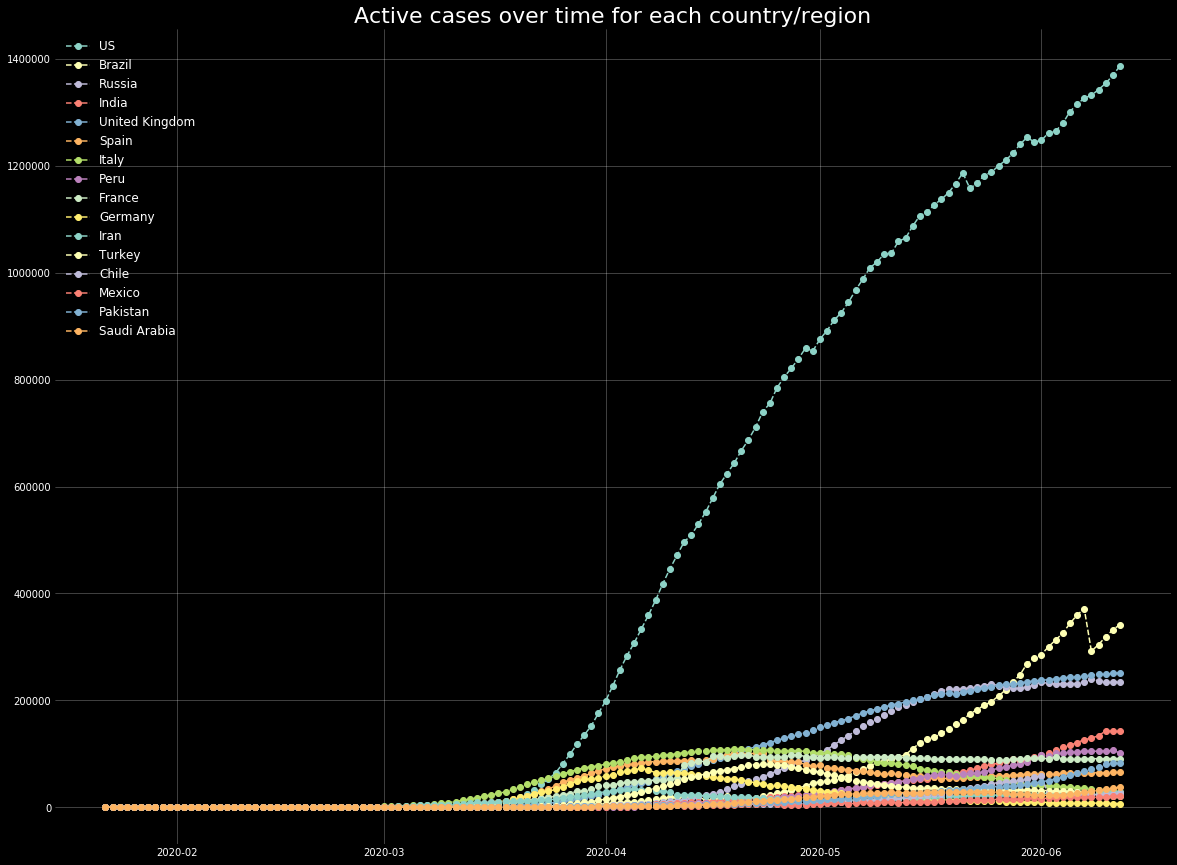

In [490]:
plot_overtime(df_affected,'Active','dark_background')

<Figure size 1440x1080 with 0 Axes>

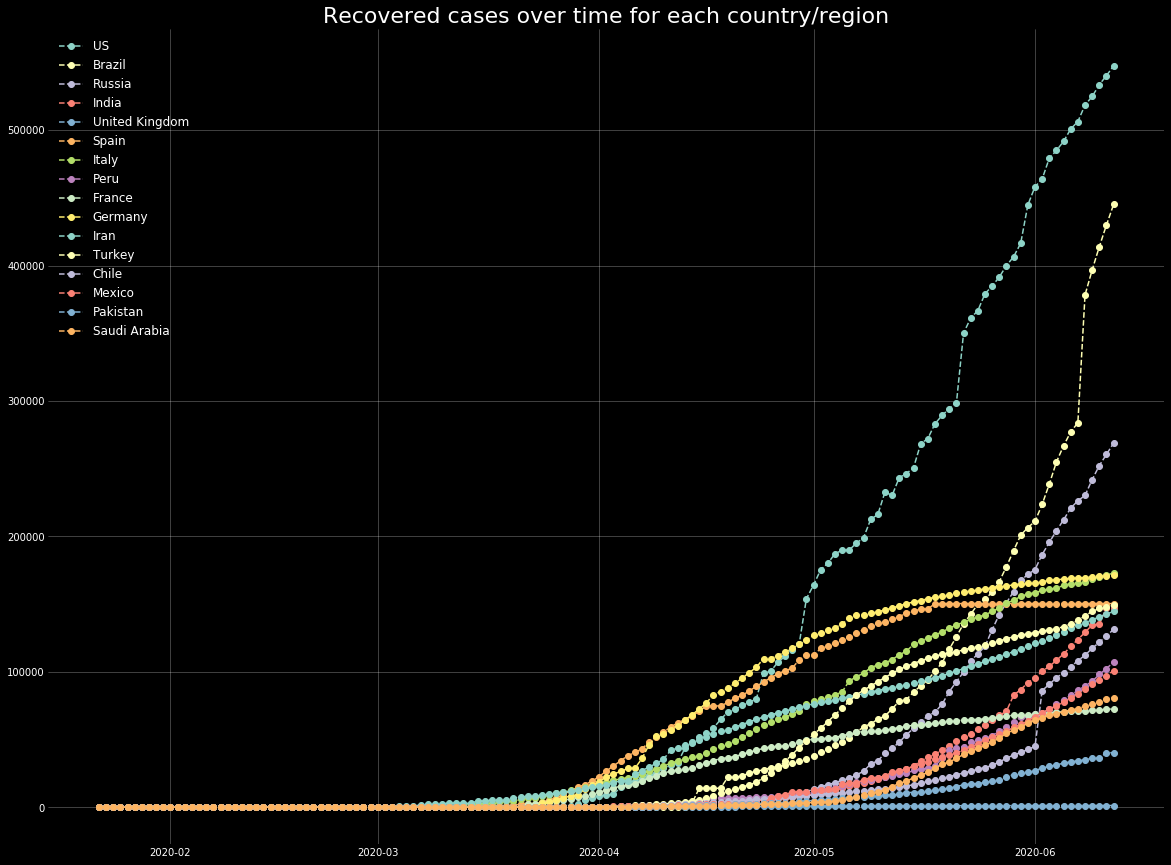

In [491]:
plot_overtime(df_affected,'Recovered','dark_background')

<Figure size 1440x1080 with 0 Axes>

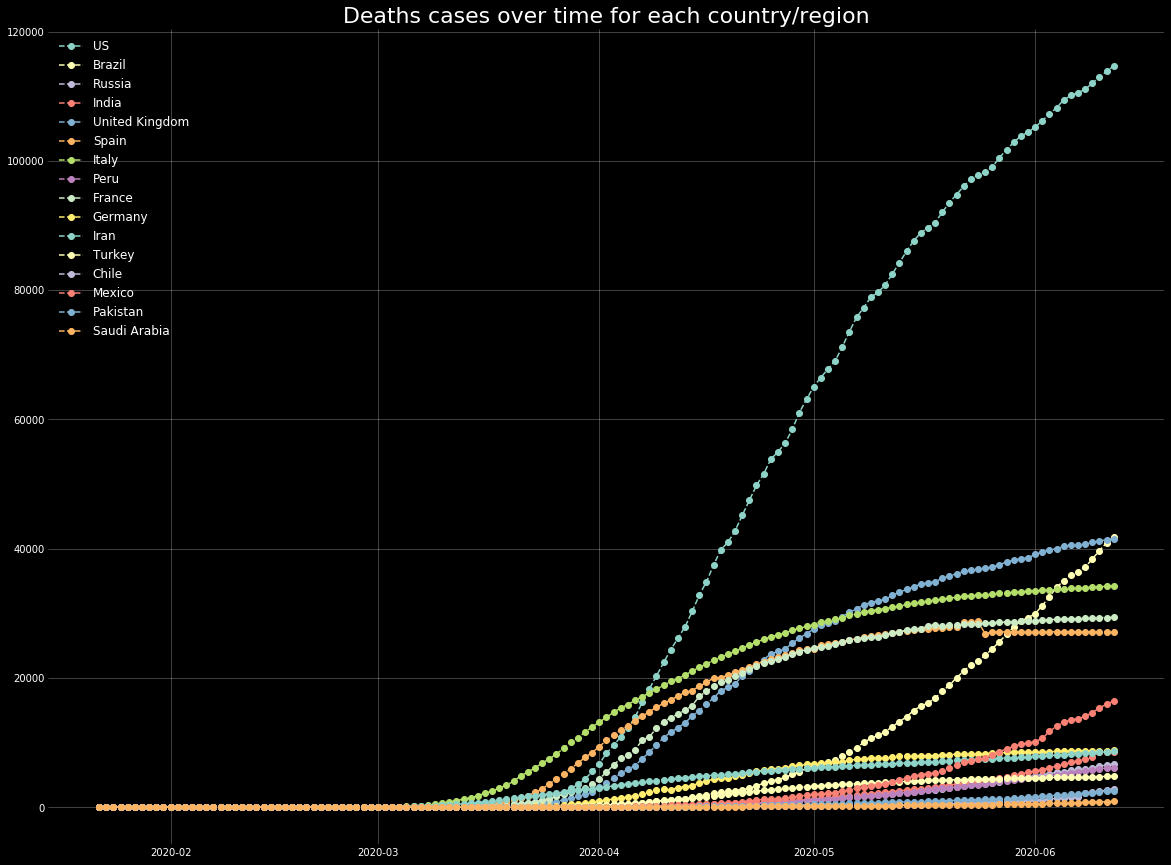

In [492]:
plot_overtime(df_affected,'Deaths','dark_background')


<Figure size 1440x1080 with 0 Axes>

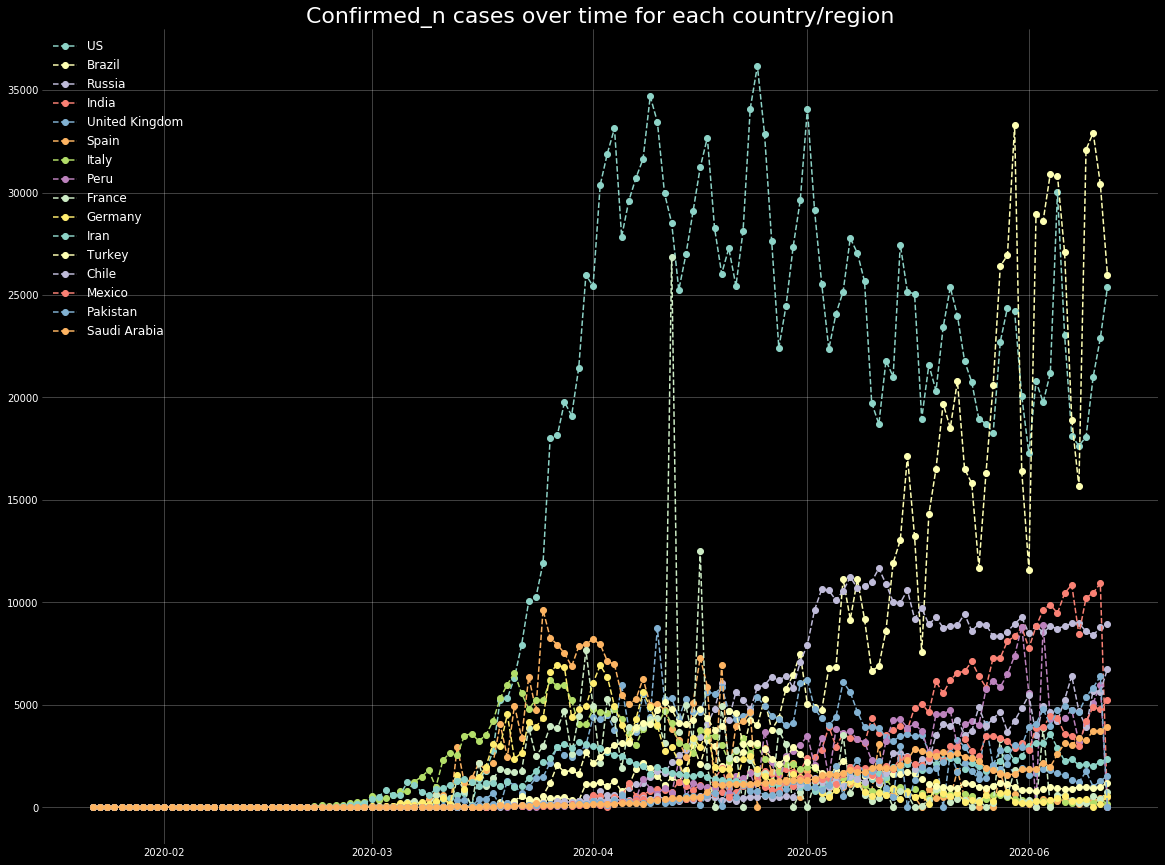

In [493]:
plot_overtime(df_affected,'Confirmed_n','dark_background')


In [494]:
World_Data[World_Data['Confirmed_n']<0]

Empty DataFrame
Columns: [Date, Country, Confirmed, Deaths, Recovered, Active, Confirmed_n, Active_n, Deaths_n, Recovered_n]
Index: []

<Figure size 1440x1080 with 0 Axes>

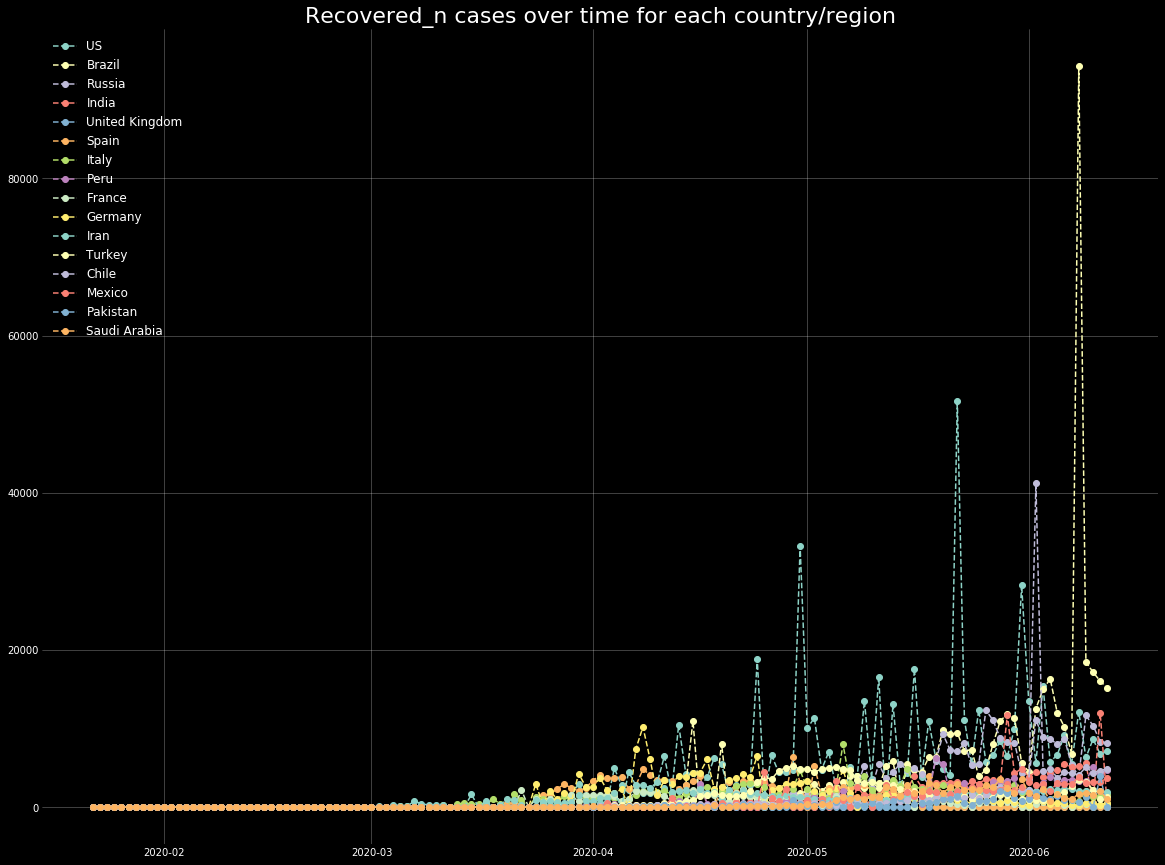

In [495]:
plot_overtime(df_affected,'Recovered_n','dark_background')

<Figure size 1440x1080 with 0 Axes>

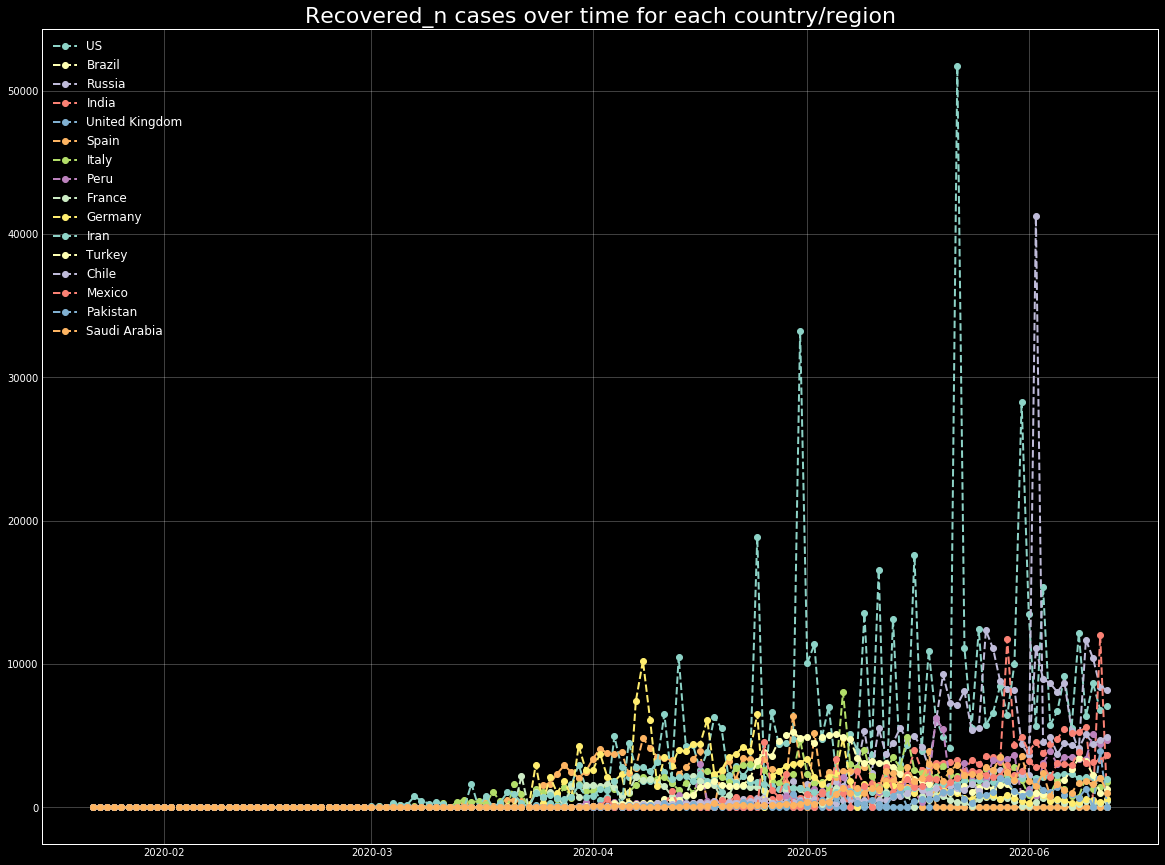

In [502]:
plot_overtime(df_affected[df_affected['Country']!='Brazil'],'Recovered_n','dark_background')

<Figure size 1440x1080 with 0 Axes>

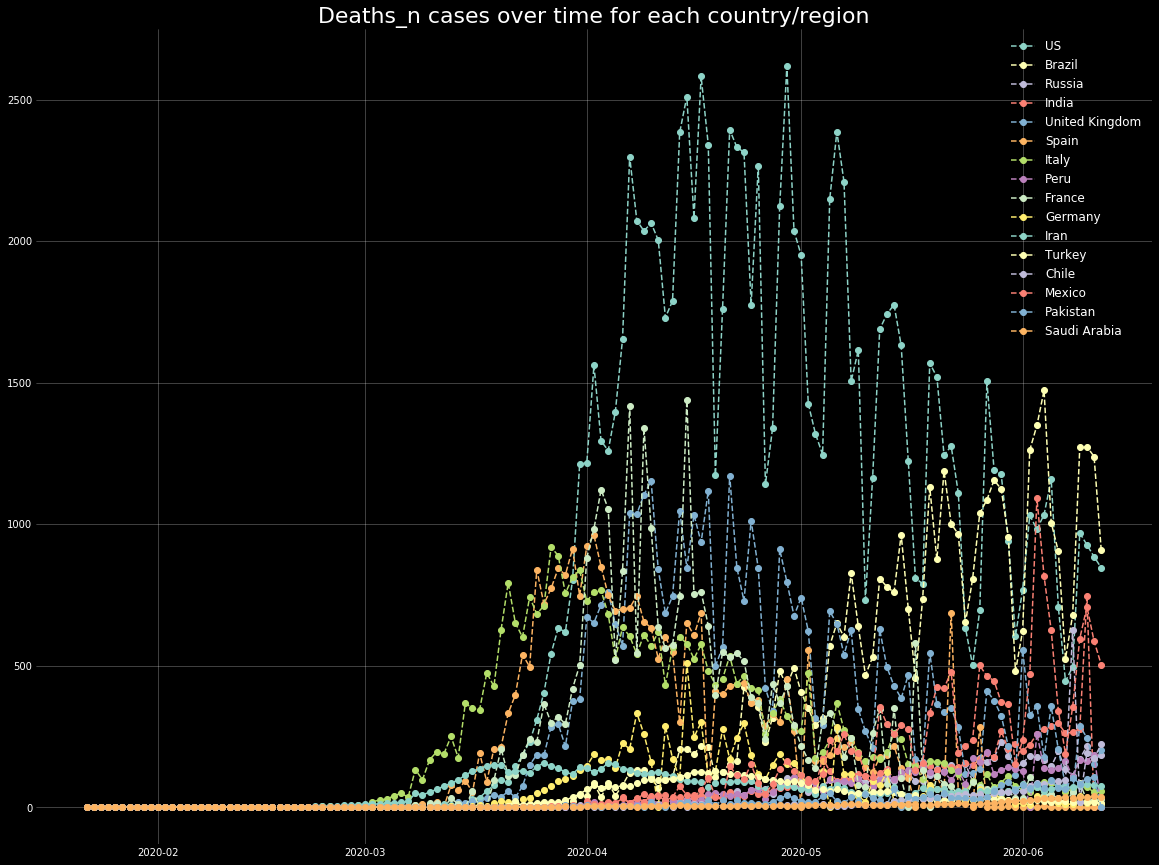

In [496]:
plot_overtime(df_affected,'Deaths_n','dark_background')

In [497]:
#times = df_affected['Date'].unique()
#times=df_affected['Date'].strftime('%Y-%m').unique()
#xlim=[df_affected['Date'].min(),df_affected['Date'].max()]
#ylim=[df_affected['Confirmed'].min(),df_affected['Confirmed'].max()]
#g = sns.FacetGrid(df_affected, col="Country", col_wrap=3,height=3)
#g = g.map(sns.barplot, "Date", "Confirmed",order=times)


Text(0.5, 1.0, 'Trend of Active,Death and Recovered cases in each country')

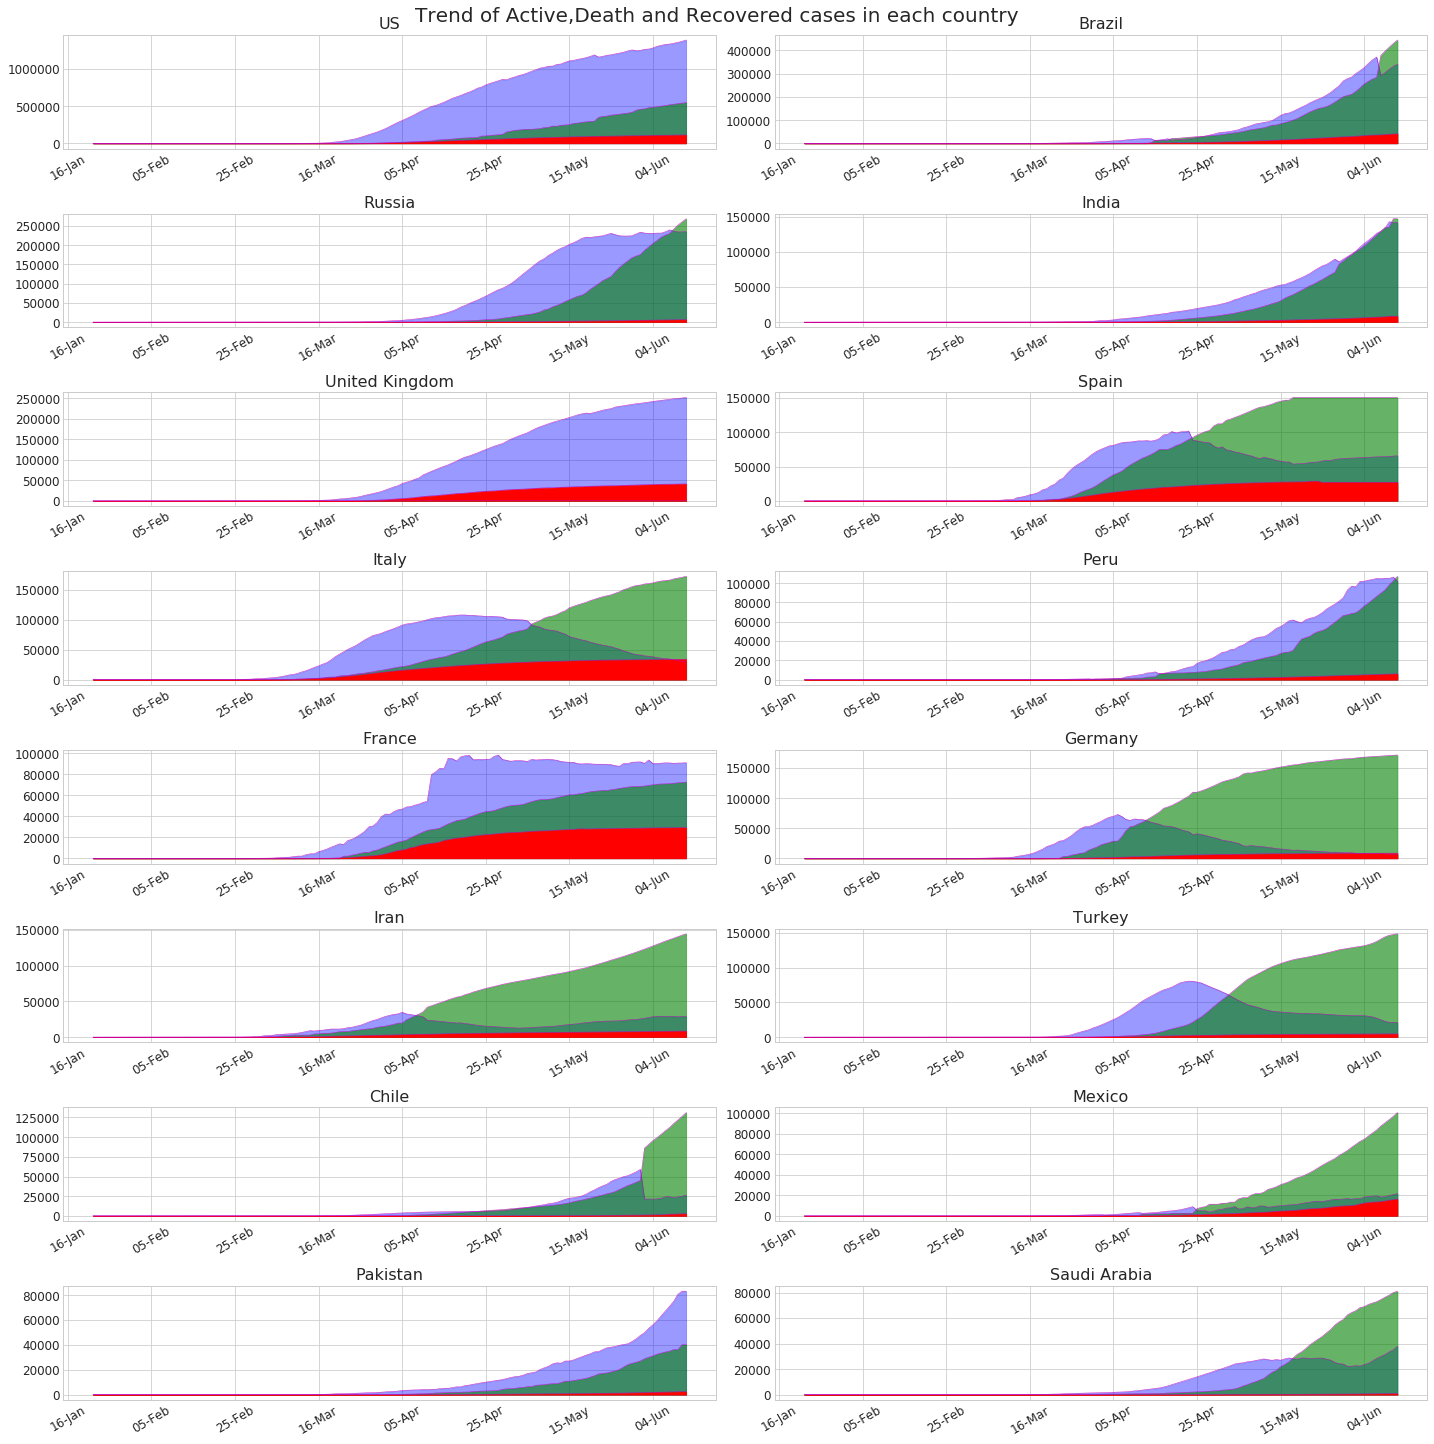

In [499]:
fig = plt.figure(figsize= (20,20))
plt.style.use('seaborn-whitegrid')

m= len(Affected)
max_rows=int((m+1)/2)
k=0
#fig,axs=plt.subplots(int(max_rows),2,figsize= (16,20),sharex=True,sharey=True)
for i,k in zip(Affected,range(1,m+1)):
    axs=fig.add_subplot(max_rows,2,k)
    df=df_affected[df_affected['Country']==i]
    axs.fill_between(df['Date'],df['Active'],color='blue',label = 'Active',alpha=0.4)
    axs.plot(df['Date'],df['Active'],color='m',linewidth=0.5,alpha=0.9)
    axs.fill_between(df['Date'],df['Recovered'],color='green',label='Recovered',alpha=0.6)
    axs.plot(df['Date'],df['Recovered'],color='m',linewidth=0.5,alpha=0.9)
    axs.fill_between(df['Date'],df['Deaths'],color='red',label='Deaths')
    axs.plot(df['Date'],df['Deaths'],color='m',linewidth=0.5,alpha=0.9)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=30,fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(i,fontsize=16)
    plt.locator_params(axis='y', nbins=6)
    axs.xaxis.set_major_locator(ticker.MultipleLocator(20))
    
    k=k+1
plt.tight_layout(pad=1)
plt.suptitle('Trend of Active,Death and Recovered cases in each country',fontsize = 20,y=1.0)


With this plot, we can observe the trend of active cases, recoveries and deaths in each country which gives an idea on whether recoveries are at an increasing pace or active cases are at an increasing pace. In Italy, Spain and Germany, recovery rate is much higher which is observed in previous plots also[recovery rate plot] and active cases rate is decreasing gradually. In contrast, US Active cases are increasing at a much higher rate than its recovery rate.India, Pakistan and Peru showed almost similar trend in active cases and recovery rate. This might be because of poor lockdown regulations in US resulting in exponential growth of active cases. Lets have a look at stacked chart indicating the proportion of active , recovered and death cases in each country.

Text(0.5, 1.0, 'Trend of Active,Death and Recovered cases in each country[STACKED]')

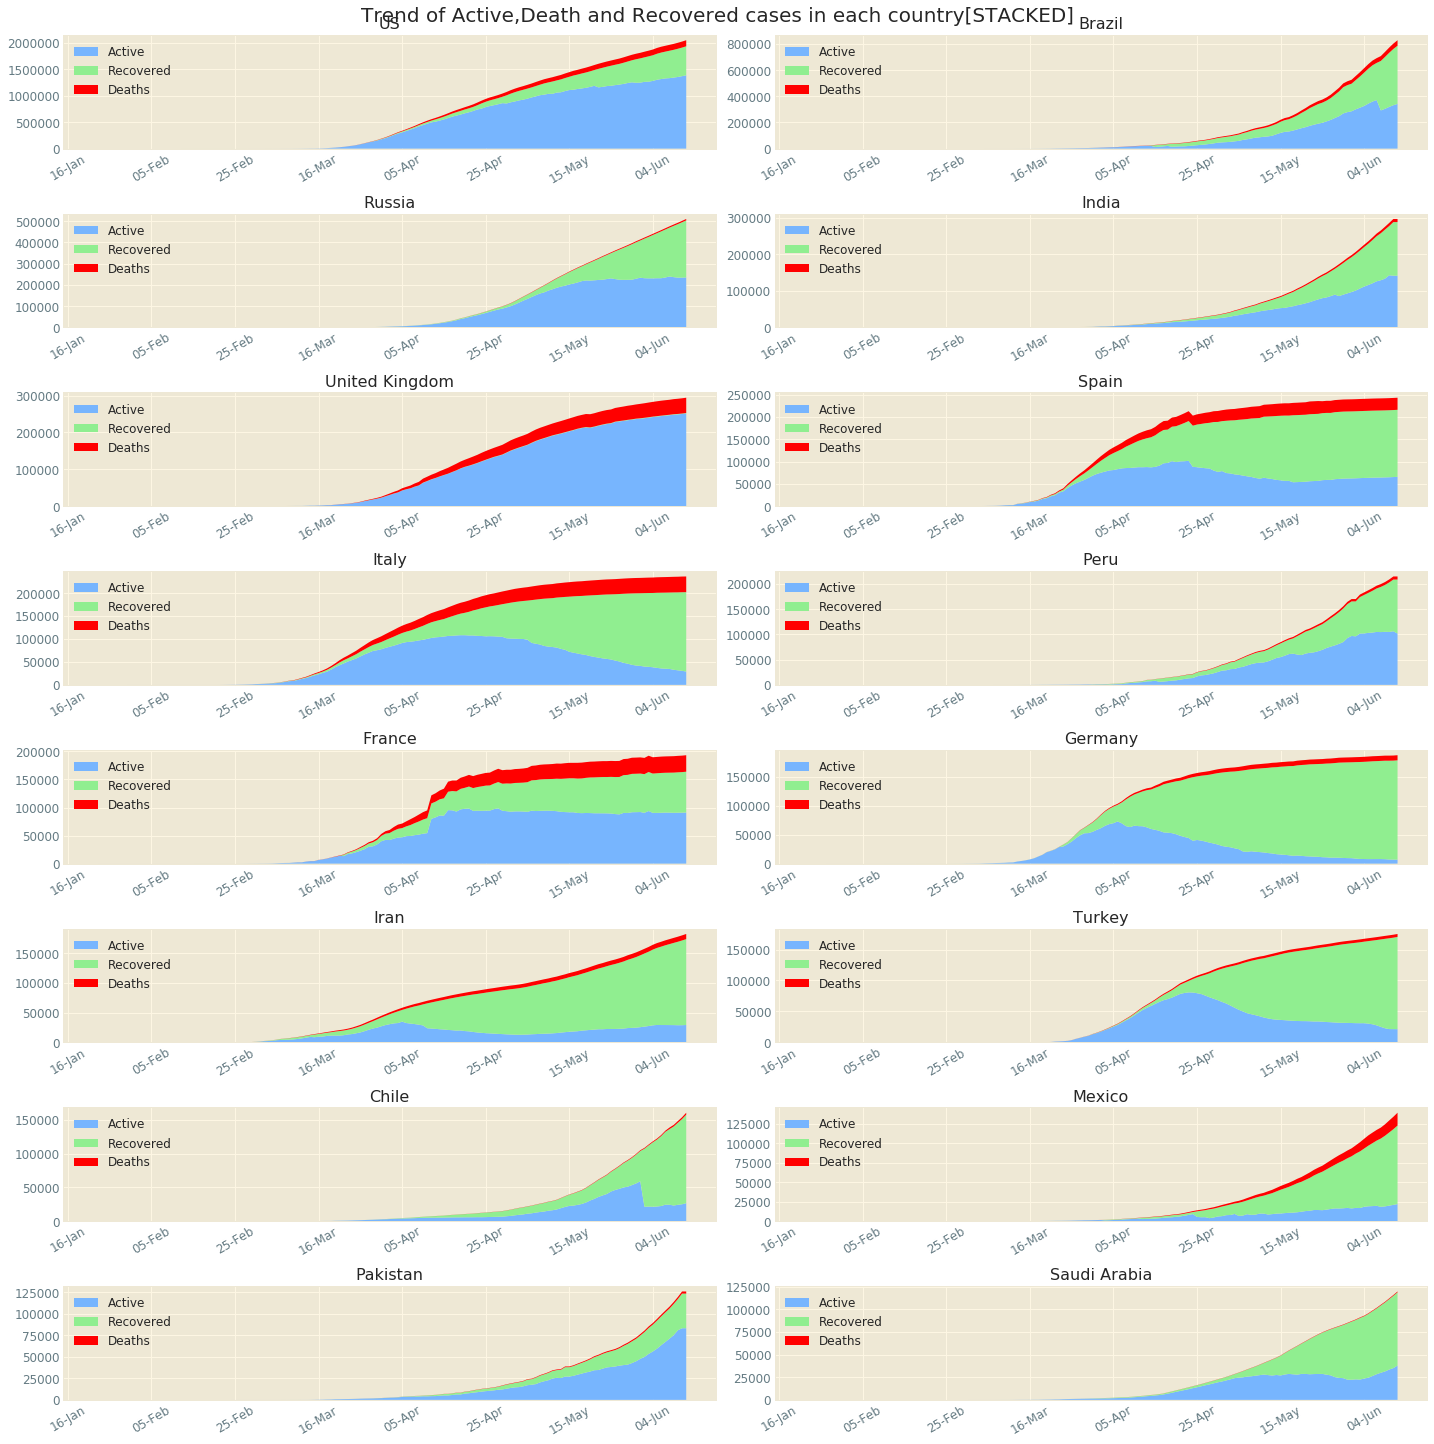

In [500]:
fig = plt.figure(figsize= (20,20))
plt.style.use('Solarize_Light2')

m= len(Affected)
max_rows=int((m+1)/2)
k=0
#fig,axs=plt.subplots(int(max_rows),2,figsize= (16,20),sharex=True,sharey=True)
for i,k in zip(Affected,range(1,m+1)):
    axs=fig.add_subplot(max_rows,2,k)
    df=df_affected[df_affected['Country']==i]
    color=['#77b5fe','#90EE90','r']
    axs.stackplot(df['Date'],df['Active'],df['Recovered'],df['Deaths'], labels=['Active','Recovered','Deaths'],colors=color)

    axs.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=30,fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(i,fontsize=16)
    plt.locator_params(axis='y', nbins=6)
    axs.xaxis.set_major_locator(ticker.MultipleLocator(20))
    plt.legend(loc='upper left',fontsize=12)
    k=k+1
plt.tight_layout(pad=1)
plt.suptitle('Trend of Active,Death and Recovered cases in each country[STACKED]',fontsize = 20,y=1.0)


As expected, Most of the countries have better recovered cases proportion and reduced active cases with time.But downward trend of active cases is not observed in some countries/regions like India,Pakistan and US.What could be possible reasons?- Number of tests done are not enough to find all existing cases? Strict lockdown is not implemented in those regions? How would be the case if there is no lockdown- exponential growth or different growth based on contacts ? Are we comparing regions just based on the confirmed cases, ignoring their population? 

In [ ]:
url = 'https://www.worldometers.info/world-population/population-by-country'
html = requests.get(url).content
popu=pd.read_html(html)
population = popu[0]
population.rename(columns={'Country (or dependency)':'Country','Population (2020)':'Population'},inplace=True)
population.head()

In [423]:
Data_r=Data_recent

Data_r= Data_r.join(population.set_index('Country')['Population'],on='Country')
Data_r[Data_r['Population'].isnull()]


Date                           Country  Confirmed  Deaths  \
26727 2020-06-12                                US    2048986  114669   
26644 2020-06-12                      Korea, South      12051     277   
26598 2020-06-12                           Czechia       9938     329   
26594 2020-06-12                     Cote d'Ivoire       4684      45   
26645 2020-06-12                            Kosovo       1326      31   
26601 2020-06-12                  Diamond Princess        712      13   
26699 2020-06-12             Sao Tome and Principe        639      12   
26736 2020-06-12                West Bank and Gaza        489       3   
26581 2020-06-12                             Burma        261       6   
26697 2020-06-12  Saint Vincent and the Grenadines         27       0   
26695 2020-06-12             Saint Kitts and Nevis         15       0   
26657 2020-06-12                        MS Zaandam          9       2   

       Recovered   Active  Deathrate  Recoveryrate  Population  
26727     547386  1386931       5.60         26.71         NaN  
26644      10691     1083       2.30         88.71         NaN  
26598       7215     2394       3.31         72.60         NaN  
26594       2263     2376       0.96         48.31         NaN  
26645        921      374       2.34         69.46         NaN  
26601        651       48       1.83         91.43         NaN  
26699        156      471       1.88         24.41         NaN  
26736        414       72       0.61         84.66         NaN  
26581        165       90       2.30         63.22         NaN  
26697         25        2       0.00         92.59         NaN  
26695         15        0       0.00        100.00         NaN  
26657          0        7      22.22          0.00         NaN

In [424]:
Data_r.loc[Data_r['Country']=='US','Population']=population.loc[population['Country']=='United States','Population'].values
Data_r.loc[Data_r['Country']=='Korea, South','Population']=population.loc[population['Country']=='South Korea','Population'].values
Data_r.loc[Data_r['Country']=='Czechia','Population']=population.loc[population['Country']=='Czech Republic (Czechia)','Population'].values
Data_r.loc[Data_r['Country']=='Cote d\'Ivoire','Population']=population.loc[population['Country']=='Côte d\'Ivoire','Population'].values

Data_r.loc[Data_r['Country']=='Sao Tome and Principe','Population']=population.loc[population['Country']=='Sao Tome & Principe','Population'].values

Data_r.loc[Data_r['Country']=='Saint Kitts and Nevis','Population']=population.loc[population['Country']=='Saint Kitts & Nevis','Population'].values
Data_r.loc[Data_r['Country']=='Saint Vincent and the Grenadines','Population']=population.loc[population['Country']=='St. Vincent & Grenadines','Population'].values
Data_r.loc[Data_r['Country']=='Kosovo','Population']=1810366
Data_r.loc[Data_r['Country']=='Burma','Population']= 54409800
Data_r.loc[Data_r['Country']=='West Bank and Gaza','Population']=4570000

Chloroeth map- animation; population extraction and confirmed percent of population ; new cases each day or daily infection rate, if no lockdown how would be confirmed cases with lockdown how it is ?- this will give the impact of strict lockdowns- may be exponential rate ; state wise cholopleth ; population; increase rate in confirmed cases from prev day; first case in each location gannt chart

In [425]:
Data_r[Data_r['Population'].isnull()]


Date           Country  Confirmed  Deaths  Recovered  Active  \
26601 2020-06-12  Diamond Princess        712      13        651      48   
26657 2020-06-12        MS Zaandam          9       2          0       7   

       Deathrate  Recoveryrate  Population  
26601       1.83         91.43         NaN  
26657      22.22          0.00         NaN

In [426]:
Data_r=Data_r.dropna(subset=['Population'])
Data_r[Data_r['Population'].isnull()]


Empty DataFrame
Columns: [Date, Country, Confirmed, Deaths, Recovered, Active, Deathrate, Recoveryrate, Population]
Index: []

Cases as a percentage of population or cases per million population--normalization 

In [427]:
Data_r['Population']=Data_r['Population'].astype('int')
Data_r['Confirmed_perM']= round(Data_r['Confirmed']/Data_r['Population']*1000000,0).astype('int')
Data_r['Recovered_perM']= round(Data_r['Recovered']/Data_r['Population']*1000000,0).astype('int')
Data_r['Deaths_perM']= round(Data_r['Deaths']/Data_r['Population']*1000000,0).astype('int')
Data_r['Active_perM']= round(Data_r['Active']/Data_r['Population']*1000000,0).astype('int')

In [428]:
Most_affected_perM=Data_r.sort_values(by=['Confirmed_perM'],ascending=False).head(20)


From this data, its clear that the countries with high number of confirmed cases are not the same as countries with high number of confirmed cases per million. As per the number of confirmed cases, India stands in top 10 but we can say that the spread of COVID is much less than other countries based on population data. 


In [429]:
Most_affected_perM.sort_values(by=['Confirmed_perM'],ascending=False)

Date     Country  Confirmed  Deaths  Recovered   Active  \
26691 2020-06-12       Qatar      76588      70      53296    23222   
26698 2020-06-12  San Marino        694      42        520      132   
26628 2020-06-12    Holy See         12       0         12        0   
26557 2020-06-12     Andorra        853      51        781       21   
26566 2020-06-12     Bahrain      17269      36      11903     5330   
26589 2020-06-12       Chile     160846    2870     131358    26618   
26646 2020-06-12      Kuwait      34952     285      25048     9619   
26705 2020-06-12   Singapore      39850      25      28040    11785   
26687 2020-06-12        Peru     214788    6088     107133   101567   
26656 2020-06-12  Luxembourg       4055     110       3918       27   
26727 2020-06-12          US    2048986  114669     547386  1386931   
26569 2020-06-12     Belarus      52520     298      27760    24462   
26631 2020-06-12     Iceland       1807      10       1794        3   
26711 2020-06-12       Spain     243209   27136     150376    65697   
26570 2020-06-12     Belgium      59819    9646      16498    33675   
26561 2020-06-12     Armenia      15281     258       5639     9384   
26636 2020-06-12     Ireland      25250    1705      22698      847   
26715 2020-06-12      Sweden      49684    4854          0    44830   
26602 2020-06-12    Djibouti       4441      38       2730     1673   
26684 2020-06-12      Panama      19211     421      13759     5031   

       Deathrate  Recoveryrate  Population  Confirmed_perM  Recovered_perM  \
26691       0.09         69.59     2881053           26583           18499   
26698       6.05         74.93       33931           20453           15325   
26628       0.00        100.00         801           14981           14981   
26557       5.98         91.56       77265           11040           10108   
26566       0.21         68.93     1701575           10149            6995   
26589       1.78         81.67    19116201            8414            6872   
26646       0.82         71.66     4270571            8184            5865   
26705       0.06         70.36     5850342            6812            4793   
26687       2.83         49.88    32971854            6514            3249   
26656       2.71         96.62      625978            6478            6259   
26727       5.60         26.71   331002651            6190            1654   
26569       0.57         52.86     9449323            5558            2938   
26631       0.55         99.28      341243            5295            5257   
26711      11.16         61.83    46754778            5202            3216   
26570      16.13         27.58    11589623            5161            1424   
26561       1.69         36.90     2963243            5157            1903   
26636       6.75         89.89     4937786            5114            4597   
26715       9.77          0.00    10099265            4920               0   
26602       0.86         61.47      988000            4495            2763   
26684       2.19         71.62     4314767            4452            3189   

       Deaths_perM  Active_perM  
26691           24         8060  
26698         1238         3890  
26628            0            0  
26557          660          272  
26566           21         3132  
26589          150         1392  
26646           67         2252  
26705            4         2014  
26687          185         3080  
26656          176           43  
26727          346         4190  
26569           32         2589  
26631           29            9  
26711          580         1405  
26570          832         2906  
26561           87         3167  
26636          345          172  
26715          481         4439  
26602           38         1693  
26684           98         1166

NameError: name 'Most_affected_perM' is not defined

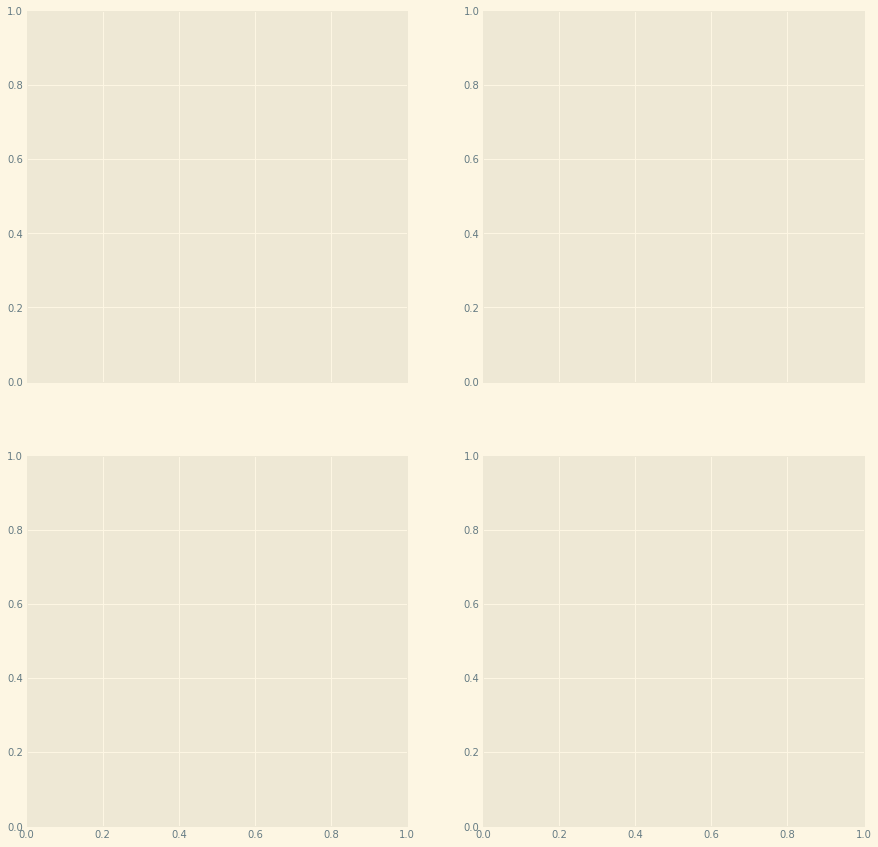

In [501]:
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)

ax1=sns.barplot(x='Confirmed_perM',y='Country',data= Most_affected_perM.sort_values(by=['Confirmed_perM'],ascending=False),color='blue',ax=axes[0, 0])
plt.setp(axes[0,0].get_xticklabels(),visible=True, rotation=30)
ax1.set_title("COVID CONFIRMED CASES per Million population")
total_c=[]

for i in ax1.patches:
    ax1.text(i.get_width()+.3, i.get_y()+.38,int(i.get_width()), fontsize=12,color='dimgrey')

ax2=sns.barplot(x='Deaths_perM',y='Country',data= Most_affected_perM.sort_values(by=['Deaths_perM'],ascending=False),color='red',ax=axes[0, 1])
plt.setp(axes[0,1].get_xticklabels(), rotation=30)
ax2.set_title("COVID DEATH CASES per Million population")
total_c=[]

for i in ax2.patches:
    ax2.text(i.get_width()+.3, i.get_y()+.38,int(i.get_width()), fontsize=12,color='dimgrey')
ax3=sns.barplot(x='Active_perM',y='Country',data= Most_affected_perM.sort_values(by=['Active_perM'],ascending=False),color='m',ax=axes[1, 0])
plt.setp(axes[1,0].get_xticklabels(), rotation=30)
ax3.set_title("COVID ACTIVE CASES per Million population")
total_c=[]
#for i in ax3.patches:
#    total_c.append(i.get_width())
for i in ax3.patches:
    ax3.text(i.get_width()+.3, i.get_y()+.38,int(i.get_width()), fontsize=12,color='dimgrey')
ax4=sns.barplot(x='Recovered_perM',y='Country',data= Most_affected_perM.sort_values(by=['Recovered_perM'],ascending=False),color='green',ax=axes[1, 1])
plt.setp(axes[1,1].get_xticklabels(), rotation=30)

for i in ax4.patches:
    ax4.text(i.get_width()+.3, i.get_y()+.38,int(i.get_width()), fontsize=12,color='dimgrey')
ax4.set_title("COVID RECOVERED CASES per Million population")
plt.tight_layout()


TypeError: plot_overtime() missing 1 required positional argument: 'plot_style'

In [ ]:
!wget --quiet https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/world_countries.json -O world_countries.json
    
print('GeoJSON file downloaded!')
world_geo = r'world_countries.json' # geojson file

# create a plain world map

w= folium.Map(location=[0,0],zoom_start=2,tiles='Mapbox Bright')
folium.Choropleth(
    geo_data=world_geo,
    data=Data_recent,
    columns=['Country', 'Confirmed'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='Confirmed'
).add_to(w)
w